#### Иморитирование библиотек

In [293]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

print("Библиотеки успешно загружены!")

Библиотеки успешно загружены!


#### Загрузка и анализ данных

=== УЛУЧШЕННАЯ ОБРАБОТКА ДАННЫХ ===
Размер данных до обработки: (260640, 10)
Типы данных:
index                      int64
Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

=== АНАЛИЗ ПРОПУСКОВ ДО ОБРАБОТКИ ===
Пропуски по столбцам:
  Global_active_power: 3771 пропусков (1.45%)
  Global_reactive_power: 3771 пропусков (1.45%)
  Voltage: 3771 пропусков (1.45%)
  Global_intensity: 3771 пропусков (1.45%)
  Sub_metering_1: 3771 пропусков (1.45%)
  Sub_metering_2: 3771 пропусков (1.45%)
  Sub_metering_3: 3771 пропусков (1.45%)
В наборе 'Потребление электроэнергии': 26397 пропусков (1.01%)


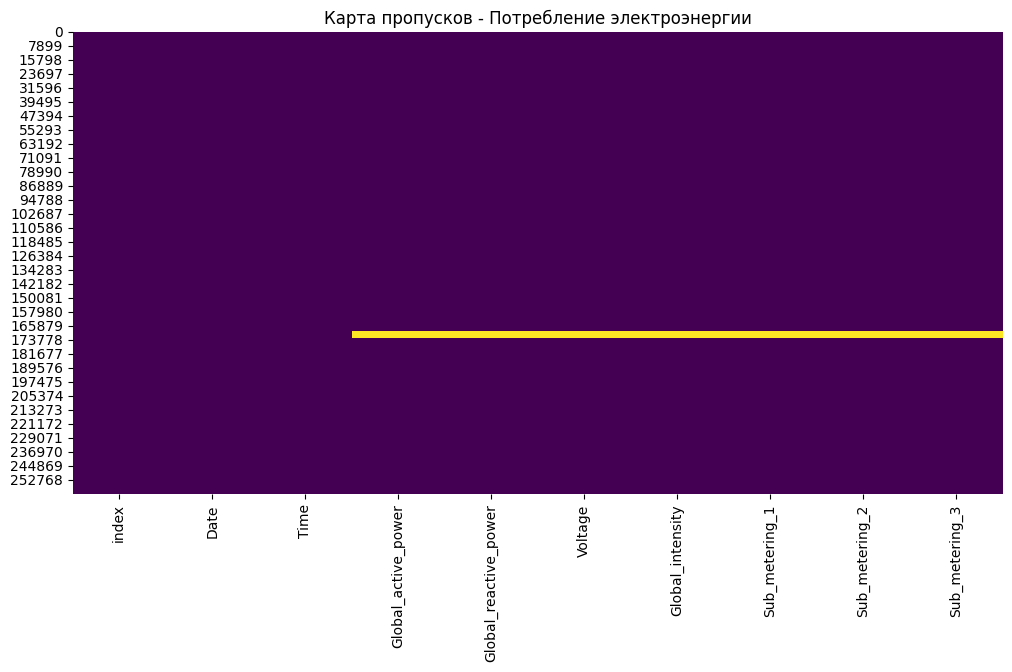

In [294]:
# УЛУЧШЕННАЯ ОБРАБОТКА ДАННЫХ
print("=== УЛУЧШЕННАЯ ОБРАБОТКА ДАННЫХ ===")

# Определяем ВСЕ возможные значения пропусков
MISSING_VALUES = ['?', '', ' ', 'null', 'NULL', 'NaN', 'nan', 'None', 'N/A', 'n/a', '#N/A', '--', '-', '...', 'NA', 'na', 'NULL', 'Null']

# Загрузка данных с обработкой пропусков
df = pd.read_csv('df/isxod.csv', 
                 na_values=MISSING_VALUES,
                 low_memory=False,
                 dayfirst=True)

print(f"Размер данных до обработки: {df.shape}")
print(f"Типы данных:\n{df.dtypes}")

# Анализ пропусков ДО обработки
print(f"\n=== АНАЛИЗ ПРОПУСКОВ ДО ОБРАБОТКИ ===")
missing_before = df.isnull().sum()
print("Пропуски по столбцам:")
for col, count in missing_before.items():
    if count > 0:
        percent = (count / len(df)) * 100
        print(f"  {col}: {count} пропусков ({percent:.2f}%)")


# Анализ пропусков
def analyze_missing_data(dataframe, name):
    missing_total = dataframe.isnull().sum().sum()
    missing_percent = (missing_total / (dataframe.shape[0] * dataframe.shape[1])) * 100
    print(f"В наборе '{name}': {missing_total} пропусков ({missing_percent:.2f}%)")
    
    # Визуализация пропусков
    plt.figure(figsize=(12, 6))
    sns.heatmap(dataframe.isnull(), cbar=False, cmap='viridis')
    plt.title(f"Карта пропусков - {name}")
    plt.show()

analyze_missing_data(df, "Потребление электроэнергии")

#### Предобработка 

In [295]:
# ОБРАБОТКА СТРОКОВЫХ ДАННЫХ
print(f"\n=== ОБРАБОТКА СТРОКОВЫХ ДАННЫХ ===")

# Проверяем строковые столбцы
string_columns = df.select_dtypes(include=['object']).columns
print(f"Строковые столбцы: {list(string_columns)}")

# Для Date и Time - удаляем строки с пропусками (так как это критично)
initial_count = len(df)
df = df.dropna(subset=['Date', 'Time'])
print(f"Удалено строк с пропусками в Date/Time: {initial_count - len(df)}")

# Проверяем качество строковых данных
print(f"\n=== КАЧЕСТВО СТРОКОВЫХ ДАННЫХ ===")
for col in string_columns:
    unique_count = df[col].nunique()
    sample_values = df[col].head(3).tolist()
    print(f"{col}: {unique_count} уникальных значений, примеры: {sample_values}")

# ОБРАБОТКА ЧИСЛОВЫХ ДАННЫХ
print(f"\n=== ОБРАБОТКА ЧИСЛОВЫХ ДАННЫХ ===")
numeric_columns = df.select_dtypes(include=[np.number]).columns

for col in numeric_columns:
    if df[col].isnull().any():
        missing_count = df[col].isnull().sum()
        median_val = df[col].median()
        print(f"  {col}: заполняем {missing_count} пропусков медианой {median_val:.4f}")
        df[col] = df[col].fillna(median_val)

# Анализ пропусков ПОСЛЕ обработки
print(f"\n=== РЕЗУЛЬТАТЫ ОБРАБОТКИ ===")
missing_after = df.isnull().sum().sum()
print(f"Осталось пропусков после обработки: {missing_after}")
print(f"Финальный размер данных: {df.shape}")

# Проверяем аномалии в числовых данных
print(f"\n=== ПРОВЕРКА АНОМАЛИЙ ===")
for col in numeric_columns:
    if col != 'index':  # Пропускаем индекс
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        if len(outliers) > 0:
            print(f"  {col}: {len(outliers)} выбросов ({len(outliers)/len(df)*100:.2f}%)")


=== ОБРАБОТКА СТРОКОВЫХ ДАННЫХ ===
Строковые столбцы: ['Date', 'Time']
Удалено строк с пропусками в Date/Time: 0

=== КАЧЕСТВО СТРОКОВЫХ ДАННЫХ ===
Date: 181 уникальных значений, примеры: ['1/1/07', '1/1/07', '1/1/07']
Time: 1440 уникальных значений, примеры: ['0:00:00', '0:01:00', '0:02:00']

=== ОБРАБОТКА ЧИСЛОВЫХ ДАННЫХ ===
  Global_active_power: заполняем 3771 пропусков медианой 0.5640
  Global_reactive_power: заполняем 3771 пропусков медианой 0.1040
  Voltage: заполняем 3771 пропусков медианой 239.6100
  Global_intensity: заполняем 3771 пропусков медианой 2.6000
  Sub_metering_1: заполняем 3771 пропусков медианой 0.0000
  Sub_metering_2: заполняем 3771 пропусков медианой 0.0000
  Sub_metering_3: заполняем 3771 пропусков медианой 0.0000

=== РЕЗУЛЬТАТЫ ОБРАБОТКИ ===
Осталось пропусков после обработки: 0
Финальный размер данных: (260640, 10)

=== ПРОВЕРКА АНОМАЛИЙ ===
  Global_active_power: 14349 выбросов (5.51%)
  Global_reactive_power: 2295 выбросов (0.88%)
  Voltage: 657 выбросо

В наборе 'Потребление электроэнергии': 0 пропусков (0.00%)


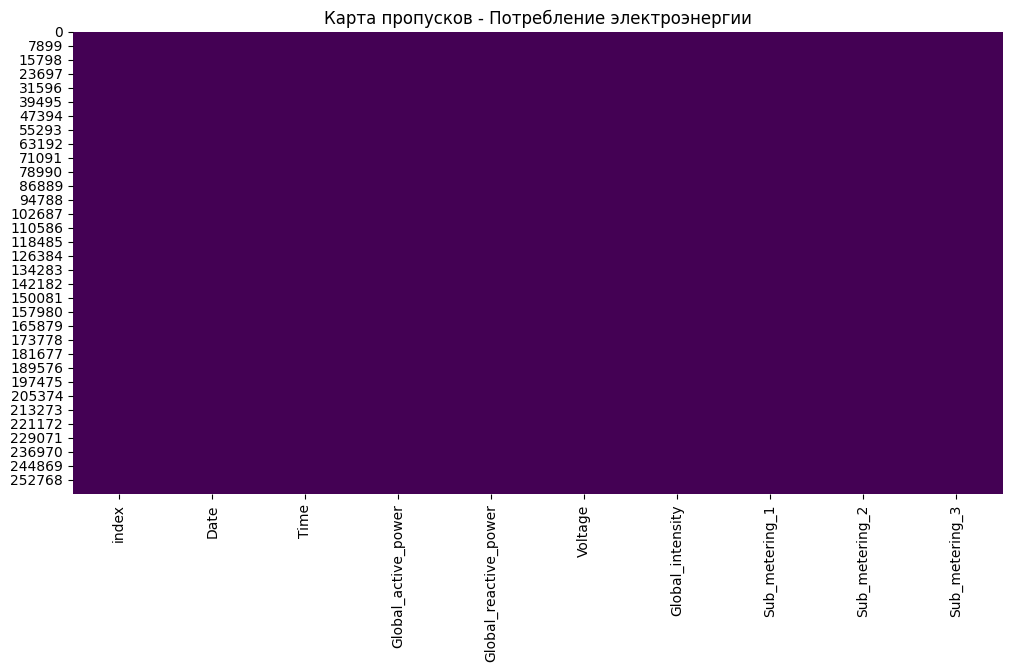

In [296]:
analyze_missing_data(df, "Потребление электроэнергии")

In [297]:
# Создаем datetime индекс С ПРАВИЛЬНЫМ ФОРМАТОМ
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)  # ДОБАВЛЕНО dayfirst=True
df = df.set_index('datetime')

# Удаляем исходные столбцы даты и времени
df = df.drop(['Date', 'Time'], axis=1)

# Удаляем столбец 'index' - теперь datetime индекс
df = df.drop('index', axis=1)

# Проверяем правильность распознавания дат ЧЕРЕЗ ИНДЕКС
print("ПРОВЕРКА ДАТ:")
print(f"Начало данных: {df.index.min()}")  # ИСПРАВЛЕНО: обращаемся к индексу
print(f"Конец данных: {df.index.max()}")    # ИСПРАВЛЕНО: обращаемся к индексу
print(f"Реальные месяцы в данных: {sorted(df.index.month.unique())}")  # ИСПРАВЛЕНО: через индекс

print("Временной индекс datetime создан")
print(f"Диапазон данных: от {df.index.min()} до {df.index.max()}")

ПРОВЕРКА ДАТ:
Начало данных: 2007-01-01 00:00:00
Конец данных: 2007-06-30 23:59:00
Реальные месяцы в данных: [1, 2, 3, 4, 5, 6]
Временной индекс datetime создан
Диапазон данных: от 2007-01-01 00:00:00 до 2007-06-30 23:59:00


In [298]:
# Создаем признаки времени (важно для сезонности)

df['hour'] = df.index.hour # (0-23)
# Пример: 
# 0 = полночь, 12 = полдень, 18 = 6 вечера
# Нужен чтобы модель понимала "ночные провалы" и "дневные пики"
# Зачем: Энергопотребление сильно зависит от времени суток


df['day_of_week'] = df.index.dayofweek # (0-6)
# 0 = понедельник, 1 = вторник, ..., 6 = воскресенье
# В данных: [0 3 6 1 4 2 5] - это просто порядок дней
# Зачем: Потребление в выходные отличается от рабочих дней


df['month'] = df.index.month # (1-12)
# 1 = январь, 12 = декабрь
# Зимой - отопление, летом - кондиционеры
# Зачем: Учесть сезонные изменения (отопление/кондиционирование)


df['is_weekend'] = (df.index.dayofweek >= 5).astype(int) # (0 или 1)
# 0 = рабочий день, 1 = суббота/воскресенье
# Упрощенная версия day_of_week
# Зачем: Быстро выделить выходные дни


df['is_morning_peak'] = ((df['hour'] >= 7) & (df['hour'] <= 9)).astype(int) # (0 или 1)
# 0 = не утренний пик, 1 = утренний пик (7:00-9:00)
# Пример: 7:00 - пробуждение, завтрак, сборы на работу
# Зачем: Выделить периоды максимального утреннего потребления


df['is_evening_peak'] = ((df['hour'] >= 18) & (df['hour'] <= 22)).astype(int) # (0 или 1)
# 0 = не вечерний пик, 1 = вечерний пик (18:00-22:00) 
# Пример: 19:00 - возвращение с работы, ужин, телевизор
# Зачем: Выделить периоды максимального вечернего потребления


df['is_night'] = ((df['hour'] >= 0) & (df['hour'] <= 5)).astype(int) # (0 или 1)
# 0 = не ночное время, 1 = ночное время (0:00-5:00)
# Пример: 3:00 - большинство людей спит, минимальное потребление
# Зачем: Выделить периоды минимального ночного потребления

print("Временные признаки созданы:")
print(f"Часы: {df['hour'].unique()}")
print(f"Дни недели: {df['day_of_week'].unique()}")
print(f"Месяцы: {sorted(df['month'].unique())}")

Временные признаки созданы:
Часы: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Дни недели: [0 1 2 3 4 5 6]
Месяцы: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6)]


In [299]:
df.sample(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day_of_week,month,is_weekend,is_morning_peak,is_evening_peak,is_night
datetime,,,,,,,,,,,,,,
2007-03-01 21:39:00,0.292,0.102,238.54,1.2,0.0,2.0,0.0,21,3,3,0,0,1,0
2007-05-03 23:30:00,1.228,0.062,237.37,5.2,0.0,0.0,17.0,23,3,5,0,0,0,0
2007-06-05 08:33:00,1.260,0.086,230.95,5.4,0.0,1.0,16.0,8,1,6,0,1,0,0
2007-04-05 23:39:00,1.524,0.188,241.46,6.2,0.0,0.0,17.0,23,3,4,0,0,0,0
2007-04-06 16:45:00,0.264,0.000,242.51,1.0,0.0,0.0,0.0,16,4,4,0,0,0,0


##### Описание столбцов датасета

| Столбец | Тип данных | Описание |
|---------|------------|-----------|
| **datetime** | DateTime | Временная метка (основной индекс) |
| **Global_active_power** | float64 | Общая активная мощность (кВт) - **целевая переменная** |
| **Global_reactive_power** | float64 | Общая реактивная мощность (кВт) |
| **Voltage** | float64 | Напряжение в сети (В) |
| **Global_intensity** | float64 | Общая сила тока (А) |
| **Sub_metering_1** | float64 | Потребление кухни (кВт) |
| **Sub_metering_2** | float64 | Потребление прачечной (кВт) |
| **Sub_metering_3** | float64 | Потребление систем отопления/охлаждения (кВт) |
| **hour** | int32 | Час дня (0-23) - **временной признак** |
| **day_of_week** | int32 | День недели (0=пн, 6=вс) - **временной признак** |
| **month** | int32 | Месяц года (1-12) - **временной признак** |
| **is_weekend** | int32 | Признак выходного дня (0=рабочий, 1=выходной) - **временной признак** |
| **is_morning_peak** | int32 | Утренний пик (7:00-9:00) - **временной признак** |
| **is_evening_peak** | int32 | Вечерний пик (18:00-22:00) - **временной признак** |
| **is_night** | int32 | Ночное время (0:00-5:00) - **временной признак** |

##### Ключевые особенности:
- 🎯 **Global_active_power** - основная целевая переменная для прогнозирования
- ⏰ **Временные признаки** созданы для анализа сезонности и цикличности потребления
- 🕒 **Пиковые периоды** выделены для лучшего понимания паттернов нагрузки
- 📊 Данные собраны с минутным интервалом (высокая детализация)
- 🏠 **Sub_metering** показывают потребление по зонам дома (кухня, прачечная, системы климат-контроля)
- ⚡ Энергетические параметры взаимосвязаны (мощность, напряжение, ток)
- 📈 **Сезонные паттерны** учтены через месячные и недельные циклы
- 🌙 **Суточные циклы** выделены через часы и пиковые периоды

In [300]:
# Сохраняем обработанные данные
df.to_csv('df/obr.csv')
print("Обработанные данные сохранены в 'df/obr.csv'")

# Также сохраним sample для проверки
sample_df = df.sample(300)  # 300 случайных строк
sample_df.to_csv('df/obr_sample.csv')
print("Sample данных сохранен в 'df/obr_sample.csv'")

# Проверим размер сохраненных данных
print(f"\nРазмер полного датасета: {df.shape}")
print(f"Размер sample: {sample_df.shape}")

Обработанные данные сохранены в 'df/obr.csv'
Sample данных сохранен в 'df/obr_sample.csv'

Размер полного датасета: (260640, 14)
Размер sample: (300, 14)


#### Анализ


ДЕТАЛЬНЫЙ АНАЛИЗ ДАННЫХ С ЧИСЛОВЫМИ ЗНАЧЕНИЯМИ

=== РАСПРЕДЕЛЕНИЕ ПО ЧАСАМ ===
Количество записей по часам:
  Час  0:  10860 записей
  Час  1:  10860 записей
  Час  2:  10860 записей
  Час  3:  10860 записей
  Час  4:  10860 записей
  Час  5:  10860 записей
  Час  6:  10860 записей
  Час  7:  10860 записей
  Час  8:  10860 записей
  Час  9:  10860 записей
  Час 10:  10860 записей
  Час 11:  10860 записей
  Час 12:  10860 записей
  Час 13:  10860 записей
  Час 14:  10860 записей
  Час 15:  10860 записей
  Час 16:  10860 записей
  Час 17:  10860 записей
  Час 18:  10860 записей
  Час 19:  10860 записей
  Час 20:  10860 записей
  Час 21:  10860 записей
  Час 22:  10860 записей
  Час 23:  10860 записей

=== РАСПРЕДЕЛЕНИЕ ПО ДНЯМ НЕДЕЛИ ===
  Понедельник:  37440 записей
  Вторник:  37440 записей
  Среда:  37440 записей
  Четверг:  37440 записей
  Пятница:  37440 записей
  Суббота:  37440 записей
  Воскресенье:  36000 записей

=== РАСПРЕДЕЛЕНИЕ ПО МЕСЯЦАМ ===
  Январь:  44640 записей
  Февр

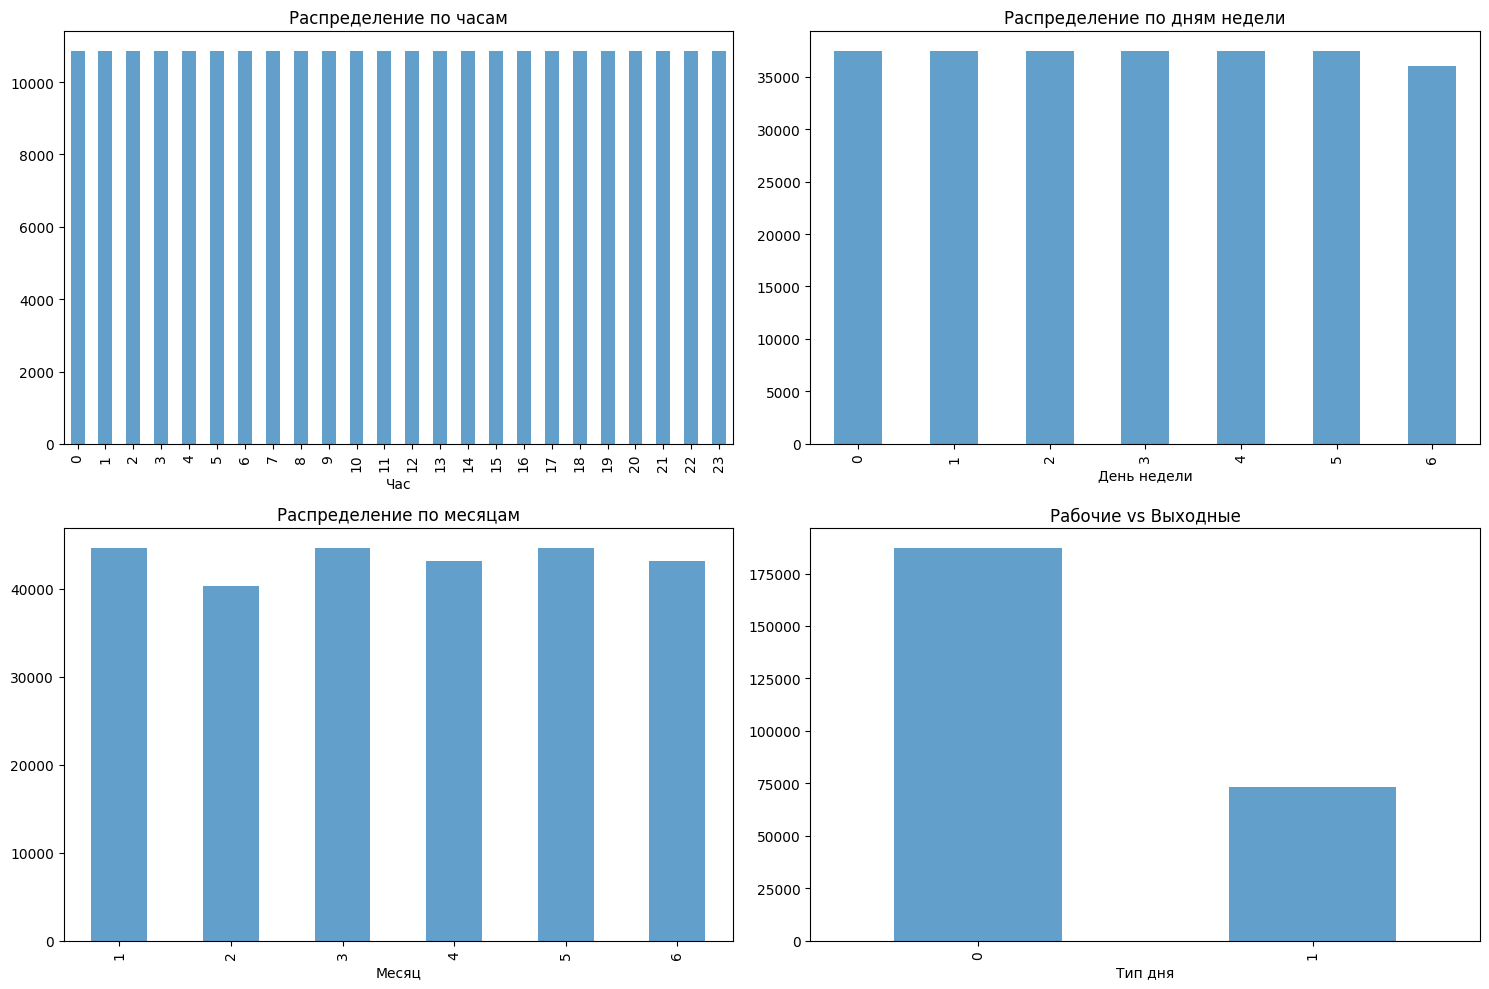

In [301]:
# УЛУЧШЕННЫЙ АНАЛИЗ С ВЫВОДОМ ЧИСЛОВЫХ ЗНАЧЕНИЙ (ИСПРАВЛЕННАЯ ВЕРСИЯ)
print("\n" + "="*60)
print("ДЕТАЛЬНЫЙ АНАЛИЗ ДАННЫХ С ЧИСЛОВЫМИ ЗНАЧЕНИЯМИ")
print("="*60)

# 1. РАСПРЕДЕЛЕНИЕ ПО ЧАСАМ (используем уже созданный признак 'hour')
print("\n=== РАСПРЕДЕЛЕНИЕ ПО ЧАСАМ ===")
hourly_counts = df['hour'].value_counts().sort_index()
print("Количество записей по часам:")
for hour in range(24):
    count = hourly_counts.get(hour, 0)
    print(f"  Час {hour:2d}: {count:6d} записей")

# 2. РАСПРЕДЕЛЕНИЕ ПО ДНЯМ НЕДЕЛИ (используем уже созданный признак)
print("\n=== РАСПРЕДЕЛЕНИЕ ПО ДНЯМ НЕДЕЛИ ===")
daily_counts = df['day_of_week'].value_counts().sort_index()
days_map = {0: 'Понедельник', 1: 'Вторник', 2: 'Среда', 3: 'Четверг', 
            4: 'Пятница', 5: 'Суббота', 6: 'Воскресенье'}

for day_num in sorted(daily_counts.index):
    day_name = days_map[day_num]
    count = daily_counts[day_num]
    print(f"  {day_name}: {count:6d} записей")

# 3. РАСПРЕДЕЛЕНИЕ ПО МЕСЯЦАМ (используем уже созданный признак)
print("\n=== РАСПРЕДЕЛЕНИЕ ПО МЕСЯЦАМ ===")
monthly_counts = df['month'].value_counts().sort_index()
months_map = {1: 'Январь', 2: 'Февраль', 3: 'Март', 4: 'Апрель', 
              5: 'Май', 6: 'Июнь'}

for month_num in sorted(monthly_counts.index):
    month_name = months_map[month_num]
    count = monthly_counts[month_num]
    print(f"  {month_name}: {count:6d} записей")

# 4. РАБОЧИЕ VS ВЫХОДНЫЕ (используем уже созданный признак)
print("\n=== РАБОЧИЕ VS ВЫХОДНЫЕ ===")
weekend_counts = df['is_weekend'].value_counts().sort_index()
for is_weekend in sorted(weekend_counts.index):
    day_type = "Выходные" if is_weekend == 1 else "Рабочие"
    count = weekend_counts[is_weekend]
    percentage = (count / len(df)) * 100
    print(f"  {day_type}: {count:6d} записей ({percentage:.1f}%)")

# 5. АНАЛИЗ ПИКОВЫХ ПЕРИОДОВ (НОВОЕ!)
print("\n=== АНАЛИЗ ПИКОВЫХ ПЕРИОДОВ ===")
print("Количество записей по пиковым периодам:")
print(f"  Утренний пик (7-9): {df['is_morning_peak'].sum():6d} записей")
print(f"  Вечерний пик (18-22): {df['is_evening_peak'].sum():6d} записей") 
print(f"  Ночное время (0-5): {df['is_night'].sum():6d} записей")

# Проверяем баланс данных
print(f"\n=== БАЛАНС ДАННЫХ ===")
print(f"Общее количество записей: {len(df):,}")
print(f"Период данных: {df.index.min()} - {df.index.max()}")
print(f"Длительность: {(df.index.max() - df.index.min()).days} дней")

# Анализ временных интервалов
print(f"\n=== ВРЕМЕННЫЕ ИНТЕРВАЛЫ ===")
time_diff = df.index.to_series().diff()
print(f"Средний интервал между измерениями: {time_diff.mean()}")
print(f"Минимальный интервал: {time_diff.min()}")
print(f"Максимальный интервал: {time_diff.max()}")

# Визуализируем распределение
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
df['hour'].value_counts().sort_index().plot(kind='bar', alpha=0.7)
plt.title('Распределение по часам')
plt.xlabel('Час')

plt.subplot(2, 2, 2)
df['day_of_week'].value_counts().sort_index().plot(kind='bar', alpha=0.7)
plt.title('Распределение по дням недели')
plt.xlabel('День недели')

plt.subplot(2, 2, 3)
df['month'].value_counts().sort_index().plot(kind='bar', alpha=0.7)
plt.title('Распределение по месяцам')
plt.xlabel('Месяц')

plt.subplot(2, 2, 4)
df['is_weekend'].value_counts().plot(kind='bar', alpha=0.7)
plt.title('Рабочие vs Выходные')
plt.xlabel('Тип дня')

plt.tight_layout()
plt.show()

ДЕТАЛЬНЫЙ АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ
Анализ целевой переменной (Global_active_power):
Количество записей: 260,640
Среднее потребление: 1.156 кВт
Медианное потребление: 0.564 кВт
Максимальное потребление: 10.670 кВт
Минимальное потребление: 0.082 кВт

=== РАСШИРЕННАЯ СТАТИСТИКА ===
Стандартное отклонение: 1.175 кВт
Дисперсия: 1.382
Коэффициент вариации: 101.7%

=== КВАНТИЛИ РАСПРЕДЕЛЕНИЯ ===
  1% перцентиль: 0.118 кВт
  5% перцентиль: 0.198 кВт
  25% перцентиль: 0.298 кВт
  50% перцентиль: 0.564 кВт
  75% перцентиль: 1.590 кВт
  95% перцентиль: 3.612 кВт
  99% перцентиль: 5.307 кВт

=== АНАЛИЗ МОДАЛЬНЫХ ЗНАЧЕНИЙ ===
Самые частые значения потребления:
  0.564 кВт: 3,923 записей (1.51%)
  0.216 кВт: 2,975 записей (1.14%)
  0.218 кВт: 2,828 записей (1.09%)
  0.220 кВт: 2,471 записей (0.95%)
  0.214 кВт: 2,150 записей (0.82%)

=== АНАЛИЗ НИЗКОГО ПОТРЕБЛЕНИЯ ===
Записей с потреблением < 0.1 кВт: 488 (0.19%)
Записей с потреблением > 5.0 кВт: 3,424 (1.31%)


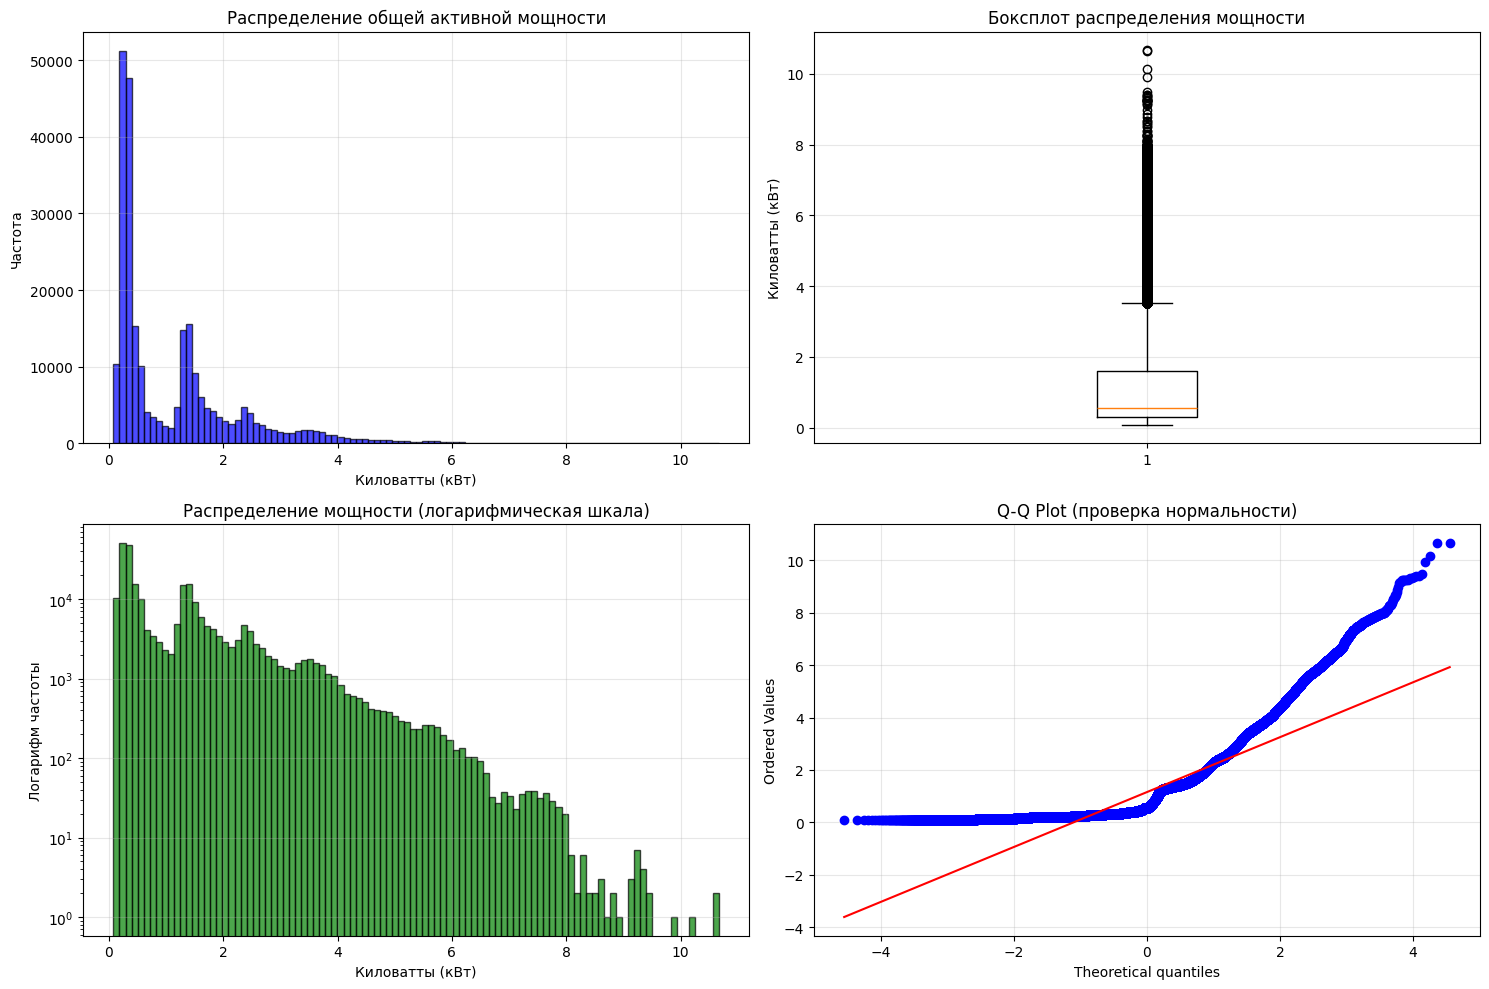

In [302]:
# ДЕТАЛЬНЫЙ АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ
print("="*60)
print("ДЕТАЛЬНЫЙ АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ")
print("="*60)

# Базовая статистика
print(f"Анализ целевой переменной (Global_active_power):")
print(f"Количество записей: {len(df):,}")
print(f"Среднее потребление: {df['Global_active_power'].mean():.3f} кВт")
print(f"Медианное потребление: {df['Global_active_power'].median():.3f} кВт")
print(f"Максимальное потребление: {df['Global_active_power'].max():.3f} кВт") 
print(f"Минимальное потребление: {df['Global_active_power'].min():.3f} кВт")

# Расширенная статистика
print(f"\n=== РАСШИРЕННАЯ СТАТИСТИКА ===")
print(f"Стандартное отклонение: {df['Global_active_power'].std():.3f} кВт")
print(f"Дисперсия: {df['Global_active_power'].var():.3f}")
print(f"Коэффициент вариации: {(df['Global_active_power'].std() / df['Global_active_power'].mean() * 100):.1f}%")

# Квантили
print(f"\n=== КВАНТИЛИ РАСПРЕДЕЛЕНИЯ ===")
quantiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
for q in quantiles:
    value = df['Global_active_power'].quantile(q)
    print(f"  {int(q*100)}% перцентиль: {value:.3f} кВт")

# Анализ мод (наиболее частых значений)
print(f"\n=== АНАЛИЗ МОДАЛЬНЫХ ЗНАЧЕНИЙ ===")
top_values = df['Global_active_power'].value_counts().head(5)
print("Самые частые значения потребления:")
for value, count in top_values.items():
    percentage = (count / len(df)) * 100
    print(f"  {value:.3f} кВт: {count:,} записей ({percentage:.2f}%)")

# Анализ нулевого и низкого потребления
low_consumption = df[df['Global_active_power'] < 0.1]
print(f"\n=== АНАЛИЗ НИЗКОГО ПОТРЕБЛЕНИЯ ===")
print(f"Записей с потреблением < 0.1 кВт: {len(low_consumption):,} ({len(low_consumption)/len(df)*100:.2f}%)")

# Анализ высокого потребления
high_consumption = df[df['Global_active_power'] > 5.0]
print(f"Записей с потреблением > 5.0 кВт: {len(high_consumption):,} ({len(high_consumption)/len(df)*100:.2f}%)")

# Визуализация распределения
plt.figure(figsize=(15, 10))

# Гистограмма распределения
plt.subplot(2, 2, 1)
plt.hist(df['Global_active_power'], bins=100, alpha=0.7, color='blue', edgecolor='black')
plt.title('Распределение общей активной мощности')
plt.xlabel('Киловатты (кВт)')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

# Боксплот
plt.subplot(2, 2, 2)
plt.boxplot(df['Global_active_power'], vert=True)
plt.title('Боксплот распределения мощности')
plt.ylabel('Киловатты (кВт)')
plt.grid(True, alpha=0.3)

# Распределение в логарифмической шкале (для лучшей визуализации)
plt.subplot(2, 2, 3)
plt.hist(df['Global_active_power'], bins=100, alpha=0.7, color='green', edgecolor='black', log=True)
plt.title('Распределение мощности (логарифмическая шкала)')
plt.xlabel('Киловатты (кВт)')
plt.ylabel('Логарифм частоты')
plt.grid(True, alpha=0.3)

# QQ-plot для проверки нормальности
plt.subplot(2, 2, 4)
from scipy import stats
stats.probplot(df['Global_active_power'], dist="norm", plot=plt)
plt.title('Q-Q Plot (проверка нормальности)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

ДЕТАЛЬНЫЙ АНАЛИЗ СУТОЧНОЙ СЕЗОННОСТИ
Среднее потребление по часам суток:
Час  Потребление (кВт)  Стандартное отклонение
  0:00   0.778 кВт          ±0.935 кВт
  1:00   0.634 кВт          ±0.769 кВт
  2:00   0.540 кВт          ±0.681 кВт
  3:00   0.517 кВт          ±0.616 кВт
  4:00   0.489 кВт          ±0.588 кВт
  5:00   0.527 кВт          ±0.634 кВт
  6:00   0.940 кВт          ±1.092 кВт
  7:00   1.518 кВт          ±1.137 кВт
  8:00   1.492 кВт          ±1.057 кВт
  9:00   1.340 кВт          ±0.948 кВт
 10:00   1.200 кВт          ±0.994 кВт
 11:00   1.102 кВт          ±1.000 кВт
 12:00   1.054 кВт          ±1.098 кВт
 13:00   1.000 кВт          ±1.056 кВт
 14:00   1.040 кВт          ±1.045 кВт
 15:00   0.996 кВт          ±1.060 кВт
 16:00   0.949 кВт          ±0.967 кВт
 17:00   1.068 кВт          ±1.067 кВт
 18:00   1.502 кВт          ±1.331 кВт
 19:00   2.069 кВт          ±1.600 кВт
 20:00   2.066 кВт          ±1.544 кВт
 21:00   2.182 кВт          ±1.466 кВт
 22:00   1.667 кВт    

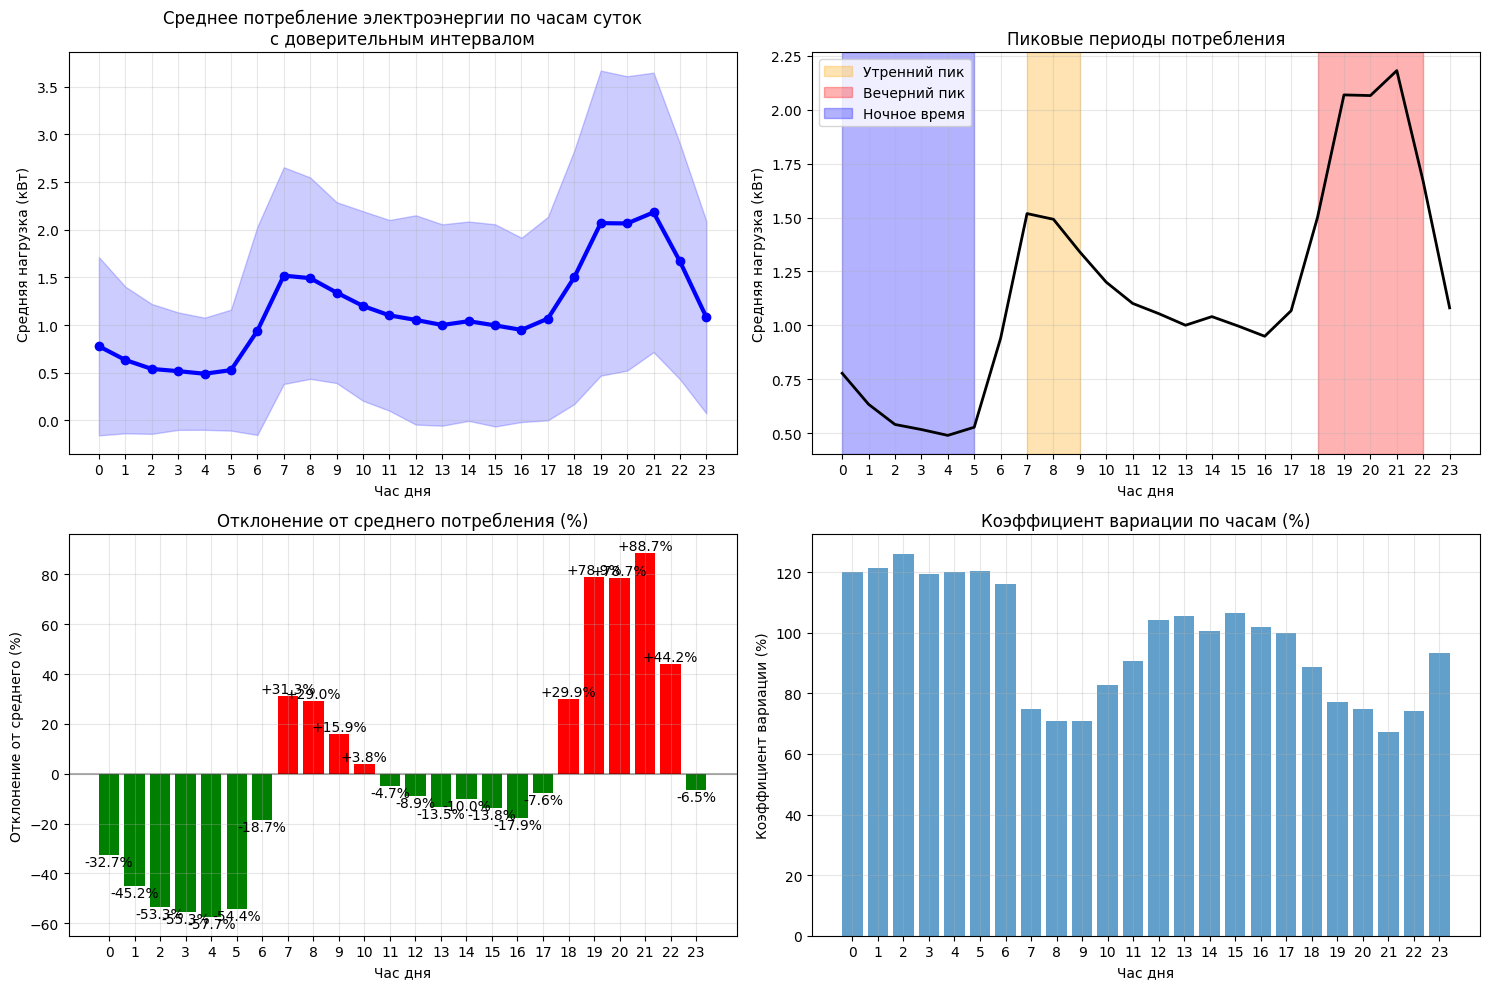

In [303]:
# ДЕТАЛЬНЫЙ АНАЛИЗ СУТОЧНОЙ СЕЗОННОСТИ
print("="*60)
print("ДЕТАЛЬНЫЙ АНАЛИЗ СУТОЧНОЙ СЕЗОННОСТИ")
print("="*60)

# Группируем по часам и считаем статистику
hourly_stats = df.groupby('hour')['Global_active_power'].agg(['mean', 'std', 'min', 'max', 'count'])
hourly_pattern = hourly_stats['mean']

print("Среднее потребление по часам суток:")
print("Час  Потребление (кВт)  Стандартное отклонение")
for hour in range(24):
    mean_val = hourly_pattern[hour]
    std_val = hourly_stats['std'][hour]
    print(f" {hour:2d}:00   {mean_val:.3f} кВт          ±{std_val:.3f} кВт")

# Анализ экстремумов
min_hour = hourly_pattern.idxmin()
max_hour = hourly_pattern.idxmax()
min_consumption = hourly_pattern.min()
max_consumption = hourly_pattern.max()

print(f"\n=== КЛЮЧЕВЫЕ ТОЧКИ СУТОЧНОГО ЦИКЛА ===")
print(f"📉 МИНИМУМ: {min_consumption:.3f} кВт в {min_hour}:00")
print(f"📈 МАКСИМУМ: {max_consumption:.3f} кВт в {max_hour}:00")
print(f"📊 РАЗМАХ: {max_consumption - min_consumption:.3f} кВт")

# Анализ пиковых периодов
print(f"\n=== АНАЛИЗ ПИКОВЫХ ПЕРИОДОВ ===")
morning_peak = hourly_pattern.loc[7:9].mean()
evening_peak = hourly_pattern.loc[18:22].mean()
night_val = hourly_pattern.loc[0:5].mean()

print(f"🌅 Утренний пик (7-9): {morning_peak:.3f} кВт")
print(f"🌇 Вечерний пик (18-22): {evening_peak:.3f} кВт") 
print(f"🌙 Ночное время (0-5): {night_val:.3f} кВт")
print(f"📈 Соотношение вечер/утро: {evening_peak/morning_peak:.2f} раза")

# Анализ роста/спада
print(f"\n=== ДИНАМИКА ИЗМЕНЕНИЙ ===")
morning_growth = hourly_pattern[7] - hourly_pattern[6]  # рост с 6 до 7
evening_growth = hourly_pattern[18] - hourly_pattern[17]  # рост с 17 до 18
night_decline = hourly_pattern[23] - hourly_pattern[22]  # спад с 22 до 23

print(f"📈 Самый резкий рост: +{morning_growth:.3f} кВт (6:00 → 7:00)")
print(f"📈 Вечерний рост: +{evening_growth:.3f} кВт (17:00 → 18:00)")
print(f"📉 Вечерний спад: {night_decline:.3f} кВт (22:00 → 23:00)")

# Визуализация
plt.figure(figsize=(15, 10))

# Основной график потребления
plt.subplot(2, 2, 1)
plt.plot(hourly_pattern.index, hourly_pattern.values, marker='o', linewidth=3, markersize=6, color='blue')
plt.fill_between(hourly_pattern.index, 
                 hourly_pattern - hourly_stats['std'],
                 hourly_pattern + hourly_stats['std'],
                 alpha=0.2, color='blue')
plt.title('Среднее потребление электроэнергии по часам суток\nс доверительным интервалом')
plt.xlabel('Час дня')
plt.ylabel('Средняя нагрузка (кВт)')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24))

# Выделение пиковых периодов
plt.subplot(2, 2, 2)
plt.plot(hourly_pattern.index, hourly_pattern.values, linewidth=2, color='black')

# Зоны пиков
plt.axvspan(7, 9, alpha=0.3, color='orange', label='Утренний пик')
plt.axvspan(18, 22, alpha=0.3, color='red', label='Вечерний пик') 
plt.axvspan(0, 5, alpha=0.3, color='blue', label='Ночное время')

plt.title('Пиковые периоды потребления')
plt.xlabel('Час дня')
plt.ylabel('Средняя нагрузка (кВт)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24))

# Сравнение с общим средним
plt.subplot(2, 2, 3)
overall_mean = df['Global_active_power'].mean()
relative_consumption = (hourly_pattern / overall_mean - 1) * 100

bars = plt.bar(relative_consumption.index, relative_consumption.values, 
               color=['red' if x > 0 else 'green' for x in relative_consumption])
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Отклонение от среднего потребления (%)')
plt.xlabel('Час дня')
plt.ylabel('Отклонение от среднего (%)')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24))

# Добавляем подписи на столбцы
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:+.1f}%', ha='center', va='bottom' if height > 0 else 'top')

# Анализ стабильности потребления
plt.subplot(2, 2, 4)
coefficient_of_variation = (hourly_stats['std'] / hourly_pattern) * 100
plt.bar(coefficient_of_variation.index, coefficient_of_variation.values, alpha=0.7)
plt.title('Коэффициент вариации по часам (%)')
plt.xlabel('Час дня')
plt.ylabel('Коэффициент вариации (%)')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24))

plt.tight_layout()
plt.show()

ДЕТАЛЬНЫЙ АНАЛИЗ НЕДЕЛЬНОЙ СЕЗОННОСТИ
Детальная статистика потребления по дням недели:
День         Среднее   Медиана   Станд.откл   Мин     Макс   Записей
Понедельник  1.094 кВт  0.574 кВт  ±1.063 кВт  0.08 кВт  9.49 кВт  37,440.0
Вторник      0.956 кВт  0.436 кВт  ±1.025 кВт  0.08 кВт  8.67 кВт  37,440.0
Среда        1.209 кВт  0.842 кВт  ±1.155 кВт  0.08 кВт  8.97 кВт  37,440.0
Четверг      1.044 кВт  0.414 кВт  ±1.109 кВт  0.10 кВт  9.41 кВт  37,440.0
Пятница      0.938 кВт  0.392 кВт  ±0.984 кВт  0.08 кВт  7.61 кВт  37,440.0
Суббота      1.290 кВт  0.708 кВт  ±1.288 кВт  0.10 кВт  9.27 кВт  37,440.0
Воскресенье  1.580 кВт  1.322 кВт  ±1.425 кВт  0.10 кВт  10.67 кВт  36,000.0

=== КЛЮЧЕВЫЕ ТОЧКИ НЕДЕЛЬНОГО ЦИКЛА ===
📉 МИНИМУМ: 0.938 кВт в Пятница
📈 МАКСИМУМ: 1.580 кВт в Воскресенье
📊 РАЗМАХ: 0.642 кВт

=== АНАЛИЗ СТАБИЛЬНОСТИ ПОТРЕБЛЕНИЯ ===
📊 Наиболее стабильный день: Воскресенье (CV: 90.2%)
📊 Наиболее изменчивый день: Вторник (CV: 107.2%)

=== ДЕТАЛЬНОЕ СРАВНЕНИЕ РАБОЧИХ И ВЫХОДН

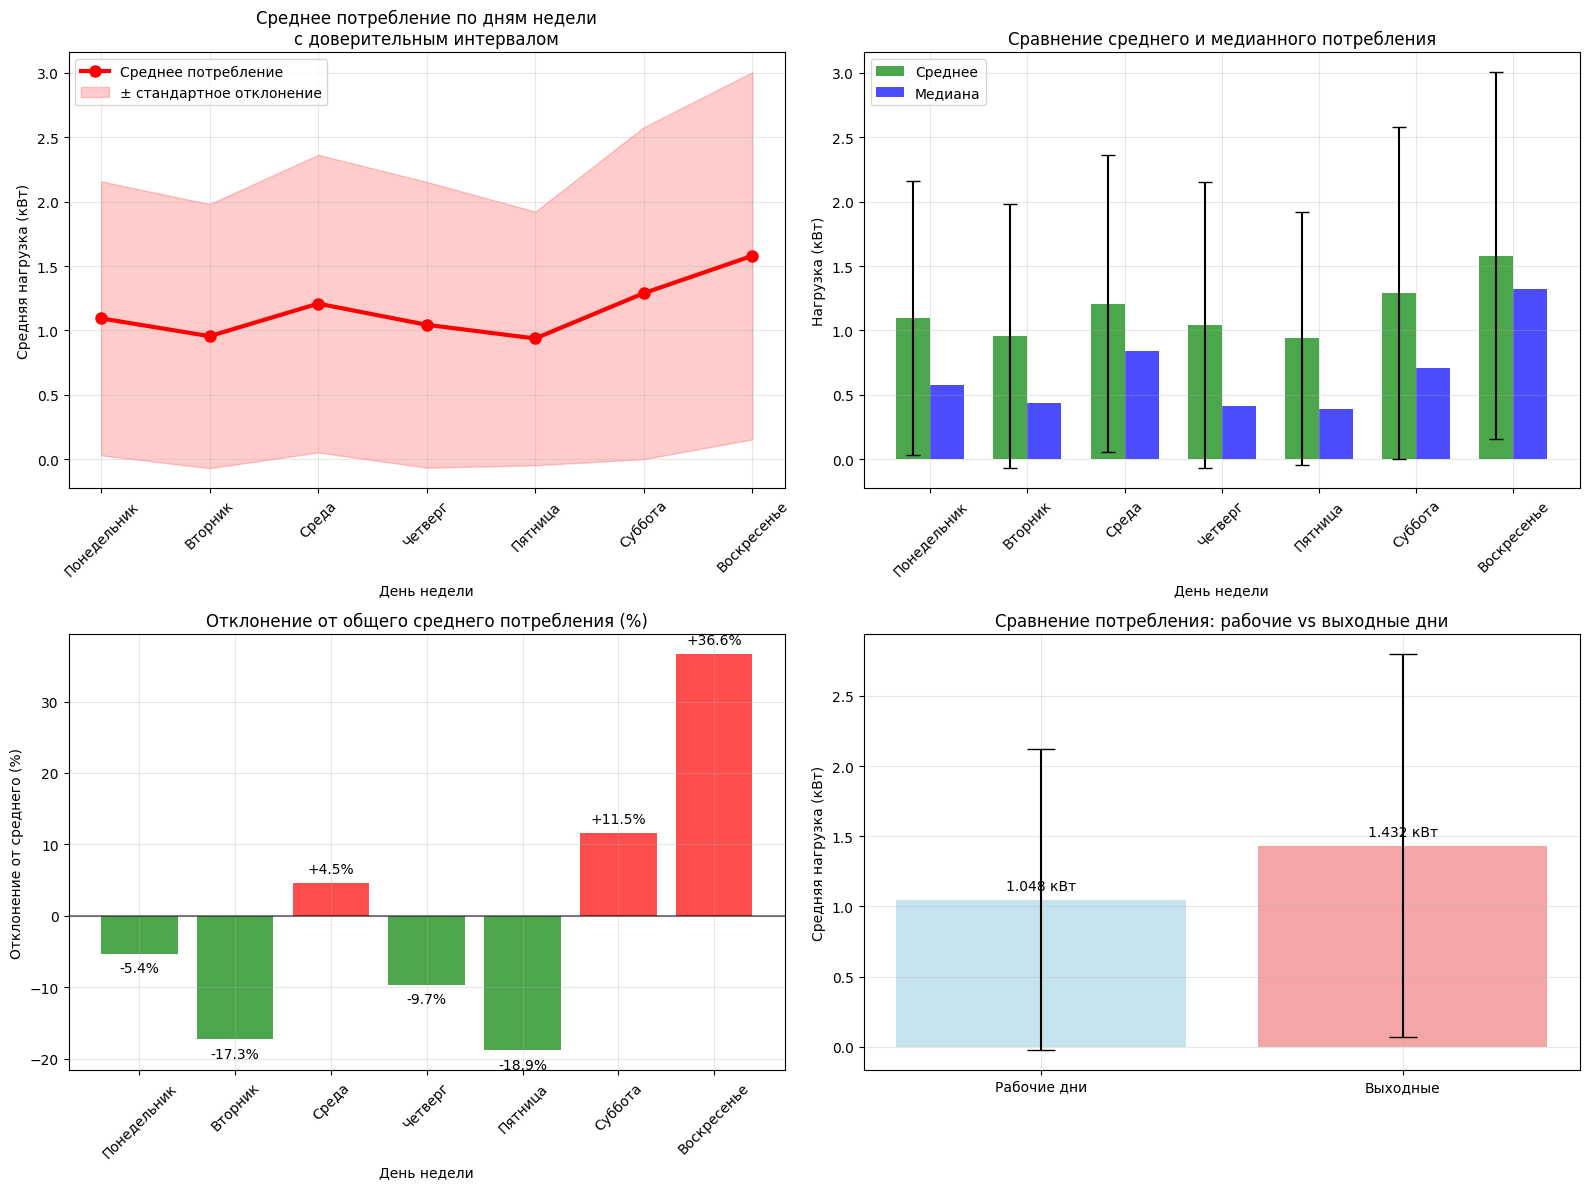

In [304]:
# ДЕТАЛЬНЫЙ АНАЛИЗ НЕДЕЛЬНОЙ СЕЗОННОСТИ
print("="*60)
print("ДЕТАЛЬНЫЙ АНАЛИЗ НЕДЕЛЬНОЙ СЕЗОННОСТИ")
print("="*60)

# Создаем словарь для правильных названий дней недели
days_map = {0: 'Понедельник', 1: 'Вторник', 2: 'Среда', 3: 'Четверг', 
            4: 'Пятница', 5: 'Суббота', 6: 'Воскресенье'}

# Группируем по дням недели и считаем расширенную статистику
weekly_stats = df.groupby('day_of_week')['Global_active_power'].agg([
    'mean', 'std', 'min', 'max', 'median', 'count'
])

print("Детальная статистика потребления по дням недели:")
print("День         Среднее   Медиана   Станд.откл   Мин     Макс   Записей")
for day in weekly_stats.index:
    day_name = days_map[day]
    stats = weekly_stats.loc[day]
    print(f"{day_name:<12} {stats['mean']:.3f} кВт  {stats['median']:.3f} кВт  "
          f"±{stats['std']:.3f} кВт  {stats['min']:.2f} кВт  {stats['max']:.2f} кВт  "
          f"{stats['count']:,}")

# Анализ экстремумов
min_day = weekly_stats['mean'].idxmin()
max_day = weekly_stats['mean'].idxmax()
min_consumption = weekly_stats['mean'].min()
max_consumption = weekly_stats['mean'].max()

print(f"\n=== КЛЮЧЕВЫЕ ТОЧКИ НЕДЕЛЬНОГО ЦИКЛА ===")
print(f"📉 МИНИМУМ: {min_consumption:.3f} кВт в {days_map[min_day]}")
print(f"📈 МАКСИМУМ: {max_consumption:.3f} кВт в {days_map[max_day]}")
print(f"📊 РАЗМАХ: {max_consumption - min_consumption:.3f} кВт")

# Анализ стабильности по дням
print(f"\n=== АНАЛИЗ СТАБИЛЬНОСТИ ПОТРЕБЛЕНИЯ ===")
cv_by_day = (weekly_stats['std'] / weekly_stats['mean']) * 100
most_stable_day = cv_by_day.idxmin()
most_variable_day = cv_by_day.idxmax()

print(f"📊 Наиболее стабильный день: {days_map[most_stable_day]} (CV: {cv_by_day[most_stable_day]:.1f}%)")
print(f"📊 Наиболее изменчивый день: {days_map[most_variable_day]} (CV: {cv_by_day[most_variable_day]:.1f}%)")

# Анализ рабочих vs выходных с детализацией
workdays_data = df[df['is_weekend'] == 0]['Global_active_power']
weekends_data = df[df['is_weekend'] == 1]['Global_active_power']

workdays_mean = workdays_data.mean()
weekends_mean = weekends_data.mean()
difference = ((weekends_mean - workdays_mean) / workdays_mean) * 100

print(f"\n=== ДЕТАЛЬНОЕ СРАВНЕНИЕ РАБОЧИХ И ВЫХОДНЫХ ===")
print(f"📅 Рабочие дни (Пн-Пт): {workdays_mean:.3f} кВт")
print(f"🎉 Выходные дни (Сб-Вс): {weekends_mean:.3f} кВт")
print(f"📈 Разница: {difference:+.1f}%")

print(f"\n📊 Статистика рабочих дней:")
print(f"  • Медиана: {workdays_data.median():.3f} кВт")
print(f"  • Стандартное отклонение: {workdays_data.std():.3f} кВт")
print(f"  • Коэффициент вариации: {(workdays_data.std() / workdays_data.mean() * 100):.1f}%")

print(f"📊 Статистика выходных дней:")
print(f"  • Медиана: {weekends_data.median():.3f} кВт")
print(f"  • Стандартное отклонение: {weekends_data.std():.3f} кВт")
print(f"  • Коэффициент вариации: {(weekends_data.std() / weekends_data.mean() * 100):.1f}%")

# Анализ по типам дней (начало/конец недели)
print(f"\n=== АНАЛИЗ ПО ТИПАМ ДНЕЙ ===")
week_start = weekly_stats.loc[0:2, 'mean'].mean()  # Пн-Ср
week_end = weekly_stats.loc[3:4, 'mean'].mean()    # Чт-Пт
weekend = weekly_stats.loc[5:6, 'mean'].mean()     # Сб-Вс

print(f"📅 Начало недели (Пн-Ср): {week_start:.3f} кВт")
print(f"📅 Конец недели (Чт-Пт): {week_end:.3f} кВт")
print(f"🎉 Выходные (Сб-Вс): {weekend:.3f} кВт")
print(f"📈 Тренд: {((week_end - week_start) / week_start * 100):+.1f}% к концу недели")

# Визуализация
plt.figure(figsize=(16, 12))

# График 1: Основной тренд по дням
plt.subplot(2, 2, 1)
days_list = [days_map[i] for i in weekly_stats.index]
plt.plot(days_list, weekly_stats['mean'], marker='o', linewidth=3, markersize=8, 
         color='red', label='Среднее потребление')
plt.fill_between(days_list, 
                 weekly_stats['mean'] - weekly_stats['std'],
                 weekly_stats['mean'] + weekly_stats['std'],
                 alpha=0.2, color='red', label='± стандартное отклонение')
plt.title('Среднее потребление по дням недели\nс доверительным интервалом')
plt.xlabel('День недели')
plt.ylabel('Средняя нагрузка (кВт)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()

# График 2: Столбчатая диаграмма с медианой
plt.subplot(2, 2, 2)
x_pos = np.arange(len(days_list))
width = 0.35

plt.bar(x_pos - width/2, weekly_stats['mean'], width, label='Среднее', 
        alpha=0.7, color='green', yerr=weekly_stats['std'], capsize=5)
plt.bar(x_pos + width/2, weekly_stats['median'], width, label='Медиана', 
        alpha=0.7, color='blue')

plt.title('Сравнение среднего и медианного потребления')
plt.xlabel('День недели')
plt.ylabel('Нагрузка (кВт)')
plt.xticks(x_pos, days_list, rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()

# График 3: Отклонение от общего среднего
plt.subplot(2, 2, 3)
overall_mean = df['Global_active_power'].mean()
relative_to_mean = (weekly_stats['mean'] / overall_mean - 1) * 100

colors = ['green' if x < 0 else 'red' for x in relative_to_mean]
bars = plt.bar(days_list, relative_to_mean, color=colors, alpha=0.7)

plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.title('Отклонение от общего среднего потребления (%)')
plt.xlabel('День недели')
plt.ylabel('Отклонение от среднего (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Добавляем подписи
for bar, value in zip(bars, relative_to_mean):
    plt.text(bar.get_x() + bar.get_width()/2, value + (1 if value > 0 else -1),
             f'{value:+.1f}%', ha='center', va='bottom' if value > 0 else 'top')

# График 4: Сравнение рабочих и выходных
plt.subplot(2, 2, 4)
categories = ['Рабочие дни', 'Выходные']
means = [workdays_mean, weekends_mean]
std_devs = [workdays_data.std(), weekends_data.std()]

bars = plt.bar(categories, means, yerr=std_devs, capsize=10, 
               alpha=0.7, color=['lightblue', 'lightcoral'])
plt.title('Сравнение потребления: рабочие vs выходные дни')
plt.ylabel('Средняя нагрузка (кВт)')
plt.grid(True, alpha=0.3)

# Добавляем значения на столбцы
for bar, mean_val in zip(bars, means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{mean_val:.3f} кВт', ha='center', va='bottom')

plt.tight_layout()
plt.show()

ДЕТАЛЬНЫЙ АНАЛИЗ МЕСЯЧНОЙ СЕЗОННОСТИ
Детальная статистика потребления по месяцам:
Месяц      Среднее   Медиана   Станд.откл   Мин     Макс    Записей
Январь     1.546 кВт  1.376 кВт  ±1.292 кВт  0.20 кВт  9.27 кВт  44,640.0
Февраль    1.401 кВт  1.266 кВт  ±1.312 кВт  0.20 кВт  9.41 кВт  40,320.0
Март       1.319 кВт  0.852 кВт  ±1.276 кВт  0.20 кВт  10.67 кВт  44,640.0
Апрель     0.863 кВт  0.406 кВт  ±0.950 кВт  0.10 кВт  8.16 кВт  43,200.0
Май        0.986 кВт  0.462 кВт  ±1.006 кВт  0.11 кВт  7.67 кВт  44,640.0
Июнь       0.827 кВт  0.356 кВт  ±0.953 кВт  0.08 кВт  7.61 кВт  43,200.0

=== КЛЮЧЕВЫЕ ТОЧКИ МЕСЯЧНОГО ЦИКЛА ===
📉 МИНИМУМ: 0.827 кВт в Июнь
📈 МАКСИМУМ: 1.546 кВт в Январь
📊 РАЗМАХ: 0.719 кВт

=== СЕЗОННЫЙ АНАЛИЗ ===
❄️  Зимние месяцы: 1.474 кВт
🌷 Весенние месяцы: 1.056 кВт
☀️  Летние месяцы: 0.827 кВт
📈 Зима → Лето: -43.9%
📈 Зима → Весна: -28.3%

=== АНАЛИЗ СТАБИЛЬНОСТИ ПОТРЕБЛЕНИЯ ===
📊 Наиболее стабильный месяц: Январь (CV: 83.6%)
📊 Наиболее изменчивый месяц: Июнь (CV: 1

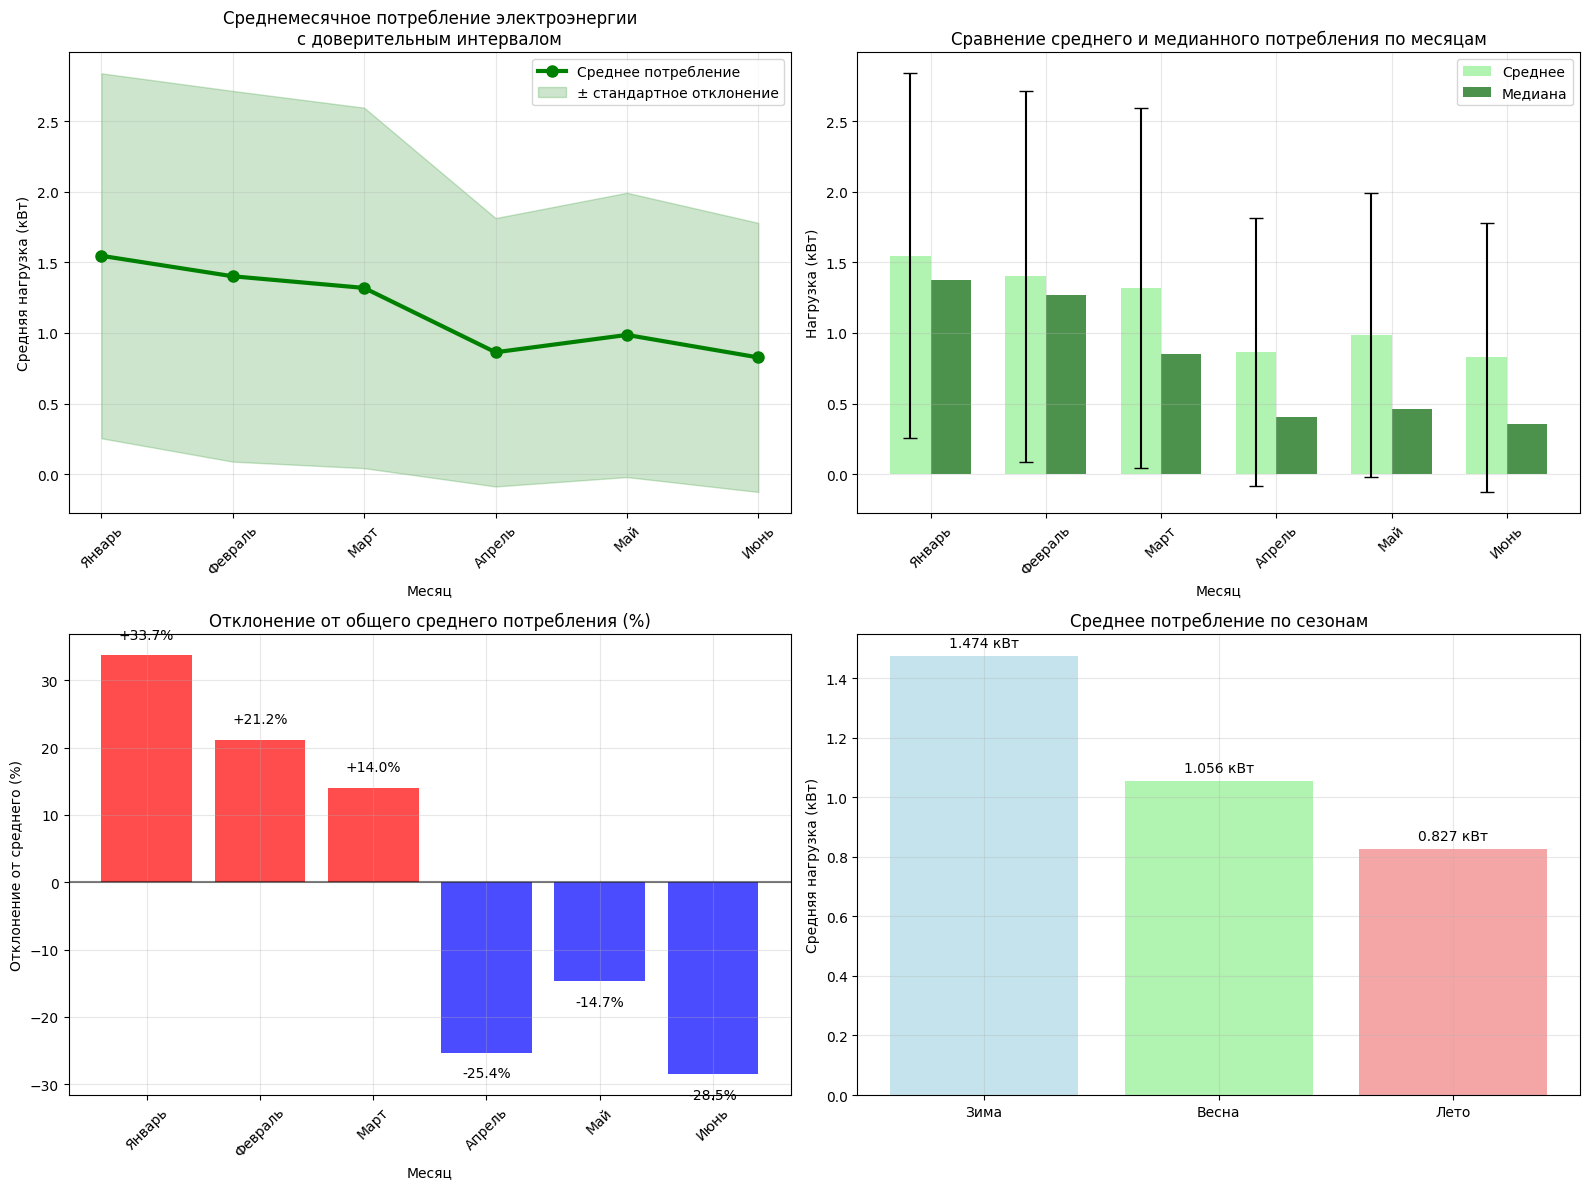

In [305]:
# ДЕТАЛЬНЫЙ АНАЛИЗ МЕСЯЧНОЙ СЕЗОННОСТИ
print("="*60)
print("ДЕТАЛЬНЫЙ АНАЛИЗ МЕСЯЧНОЙ СЕЗОННОСТИ")
print("="*60)

# Создаем словарь для названий месяцев
months_map = {1: 'Январь', 2: 'Февраль', 3: 'Март', 4: 'Апрель', 
              5: 'Май', 6: 'Июнь', 7: 'Июль', 8: 'Август',
              9: 'Сентябрь', 10: 'Октябрь', 11: 'Ноябрь', 12: 'Декабрь'}

# Группируем по месяцам и считаем расширенную статистику
monthly_stats = df.groupby('month')['Global_active_power'].agg([
    'mean', 'std', 'min', 'max', 'median', 'count'
])

print("Детальная статистика потребления по месяцам:")
print("Месяц      Среднее   Медиана   Станд.откл   Мин     Макс    Записей")
for month in monthly_stats.index:
    month_name = months_map[month]
    stats = monthly_stats.loc[month]
    print(f"{month_name:<10} {stats['mean']:.3f} кВт  {stats['median']:.3f} кВт  "
          f"±{stats['std']:.3f} кВт  {stats['min']:.2f} кВт  {stats['max']:.2f} кВт  "
          f"{stats['count']:,}")

# Анализ экстремумов
min_month = monthly_stats['mean'].idxmin()
max_month = monthly_stats['mean'].idxmax()
min_consumption = monthly_stats['mean'].min()
max_consumption = monthly_stats['mean'].max()

print(f"\n=== КЛЮЧЕВЫЕ ТОЧКИ МЕСЯЧНОГО ЦИКЛА ===")
print(f"📉 МИНИМУМ: {min_consumption:.3f} кВт в {months_map[min_month]}")
print(f"📈 МАКСИМУМ: {max_consumption:.3f} кВт в {months_map[max_month]}")
print(f"📊 РАЗМАХ: {max_consumption - min_consumption:.3f} кВт")

# Анализ сезонных паттернов
print(f"\n=== СЕЗОННЫЙ АНАЛИЗ ===")
winter_months = [1, 2]    # Январь, Февраль
spring_months = [3, 4, 5] # Март, Апрель, Май
summer_months = [6]       # Июнь

winter_consumption = monthly_stats.loc[winter_months, 'mean'].mean()
spring_consumption = monthly_stats.loc[spring_months, 'mean'].mean()
summer_consumption = monthly_stats.loc[summer_months, 'mean'].mean()

print(f"❄️  Зимние месяцы: {winter_consumption:.3f} кВт")
print(f"🌷 Весенние месяцы: {spring_consumption:.3f} кВт")
print(f"☀️  Летние месяцы: {summer_consumption:.3f} кВт")

winter_to_summer_diff = ((summer_consumption - winter_consumption) / winter_consumption) * 100
winter_to_spring_diff = ((spring_consumption - winter_consumption) / winter_consumption) * 100

print(f"📈 Зима → Лето: {winter_to_summer_diff:+.1f}%")
print(f"📈 Зима → Весна: {winter_to_spring_diff:+.1f}%")

# Анализ стабильности по месяцам
print(f"\n=== АНАЛИЗ СТАБИЛЬНОСТИ ПОТРЕБЛЕНИЯ ===")
cv_by_month = (monthly_stats['std'] / monthly_stats['mean']) * 100
most_stable_month = cv_by_month.idxmin()
most_variable_month = cv_by_month.idxmax()

print(f"📊 Наиболее стабильный месяц: {months_map[most_stable_month]} (CV: {cv_by_month[most_stable_month]:.1f}%)")
print(f"📊 Наиболее изменчивый месяц: {months_map[most_variable_month]} (CV: {cv_by_month[most_variable_month]:.1f}%)")

# Анализ тренда
print(f"\n=== АНАЛИЗ ТРЕНДА ===")
months_ordered = sorted(monthly_stats.index)
trend_values = [monthly_stats.loc[month, 'mean'] for month in months_ordered]
trend_slope = (trend_values[-1] - trend_values[0]) / len(trend_values)

if trend_slope > 0:
    trend_direction = "рост"
else:
    trend_direction = "снижение"

print(f"📊 Общий тренд: {trend_direction} ({trend_slope:.3f} кВт/месяц)")
print(f"📊 Изменение за период: {(trend_values[-1] - trend_values[0]) / trend_values[0] * 100:+.1f}%")

# Визуализация
plt.figure(figsize=(16, 12))

# График 1: Основной тренд с доверительным интервалом
plt.subplot(2, 2, 1)
months_list = [months_map[i] for i in monthly_stats.index]
plt.plot(months_list, monthly_stats['mean'], marker='o', linewidth=3, markersize=8, 
         color='green', label='Среднее потребление')
plt.fill_between(months_list, 
                 monthly_stats['mean'] - monthly_stats['std'],
                 monthly_stats['mean'] + monthly_stats['std'],
                 alpha=0.2, color='green', label='± стандартное отклонение')
plt.title('Среднемесячное потребление электроэнергии\nс доверительным интервалом')
plt.xlabel('Месяц')
plt.ylabel('Средняя нагрузка (кВт)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()

# График 2: Сравнение среднего и медианного потребления
plt.subplot(2, 2, 2)
x_pos = np.arange(len(months_list))
width = 0.35

plt.bar(x_pos - width/2, monthly_stats['mean'], width, label='Среднее', 
        alpha=0.7, color='lightgreen', yerr=monthly_stats['std'], capsize=5)
plt.bar(x_pos + width/2, monthly_stats['median'], width, label='Медиана', 
        alpha=0.7, color='darkgreen')

plt.title('Сравнение среднего и медианного потребления по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Нагрузка (кВт)')
plt.xticks(x_pos, months_list, rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()

# График 3: Отклонение от общего среднего
plt.subplot(2, 2, 3)
overall_mean = df['Global_active_power'].mean()
relative_to_mean = (monthly_stats['mean'] / overall_mean - 1) * 100

colors = ['red' if x > 0 else 'blue' for x in relative_to_mean]
bars = plt.bar(months_list, relative_to_mean, color=colors, alpha=0.7)

plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.title('Отклонение от общего среднего потребления (%)')
plt.xlabel('Месяц')
plt.ylabel('Отклонение от среднего (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Добавляем подписи
for bar, value in zip(bars, relative_to_mean):
    plt.text(bar.get_x() + bar.get_width()/2, value + (2 if value > 0 else -2),
             f'{value:+.1f}%', ha='center', va='bottom' if value > 0 else 'top')

# График 4: Сезонные паттерны
plt.subplot(2, 2, 4)
seasons = ['Зима', 'Весна', 'Лето']
season_means = [winter_consumption, spring_consumption, summer_consumption]
colors = ['lightblue', 'lightgreen', 'lightcoral']

bars = plt.bar(seasons, season_means, color=colors, alpha=0.7)
plt.title('Среднее потребление по сезонам')
plt.ylabel('Средняя нагрузка (кВт)')
plt.grid(True, alpha=0.3)

# Добавляем значения на столбцы
for bar, mean_val in zip(bars, season_means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{mean_val:.3f} кВт', ha='center', va='bottom')

plt.tight_layout()
plt.show()

ДЕТАЛЬНЫЙ АНАЛИЗ ВРЕМЕННОГО РЯДА
Анализ выбранной недели (1-7 марта 2007):
Период: 2007-03-01 00:00:00 - 2007-03-07 23:59:00
Количество записей: 10,080
Среднее потребление за неделю: 1.014 кВт
Максимальное потребление: 10.670 кВт
Минимальное потребление: 0.202 кВт

=== ПОТРЕБЛЕНИЕ ПО ДНЯМ ВЫБРАННОЙ НЕДЕЛИ ===
Понедельник: 1.847 кВт (макс: 9.49 кВт, мин: 0.21 кВт)
Вторник: 0.866 кВт (макс: 6.51 кВт, мин: 0.20 кВт)
Среда: 1.649 кВт (макс: 5.98 кВт, мин: 0.20 кВт)
Четверг: 0.359 кВт (макс: 1.47 кВт, мин: 0.21 кВт)
Пятница: 0.358 кВт (макс: 1.47 кВт, мин: 0.21 кВт)
Суббота: 0.569 кВт (макс: 4.24 кВт, мин: 0.21 кВт)
Воскресенье: 1.452 кВт (макс: 10.67 кВт, мин: 0.21 кВт)

=== ПИКОВЫЕ ПЕРИОДЫ В ВЫБРАННОЙ НЕДЕЛЕ ===
🌅 Утренний пик (7-9): 1.057 кВт
🌇 Вечерний пик (18-22): 2.059 кВт
🌙 Ночное время (0-5): 0.362 кВт


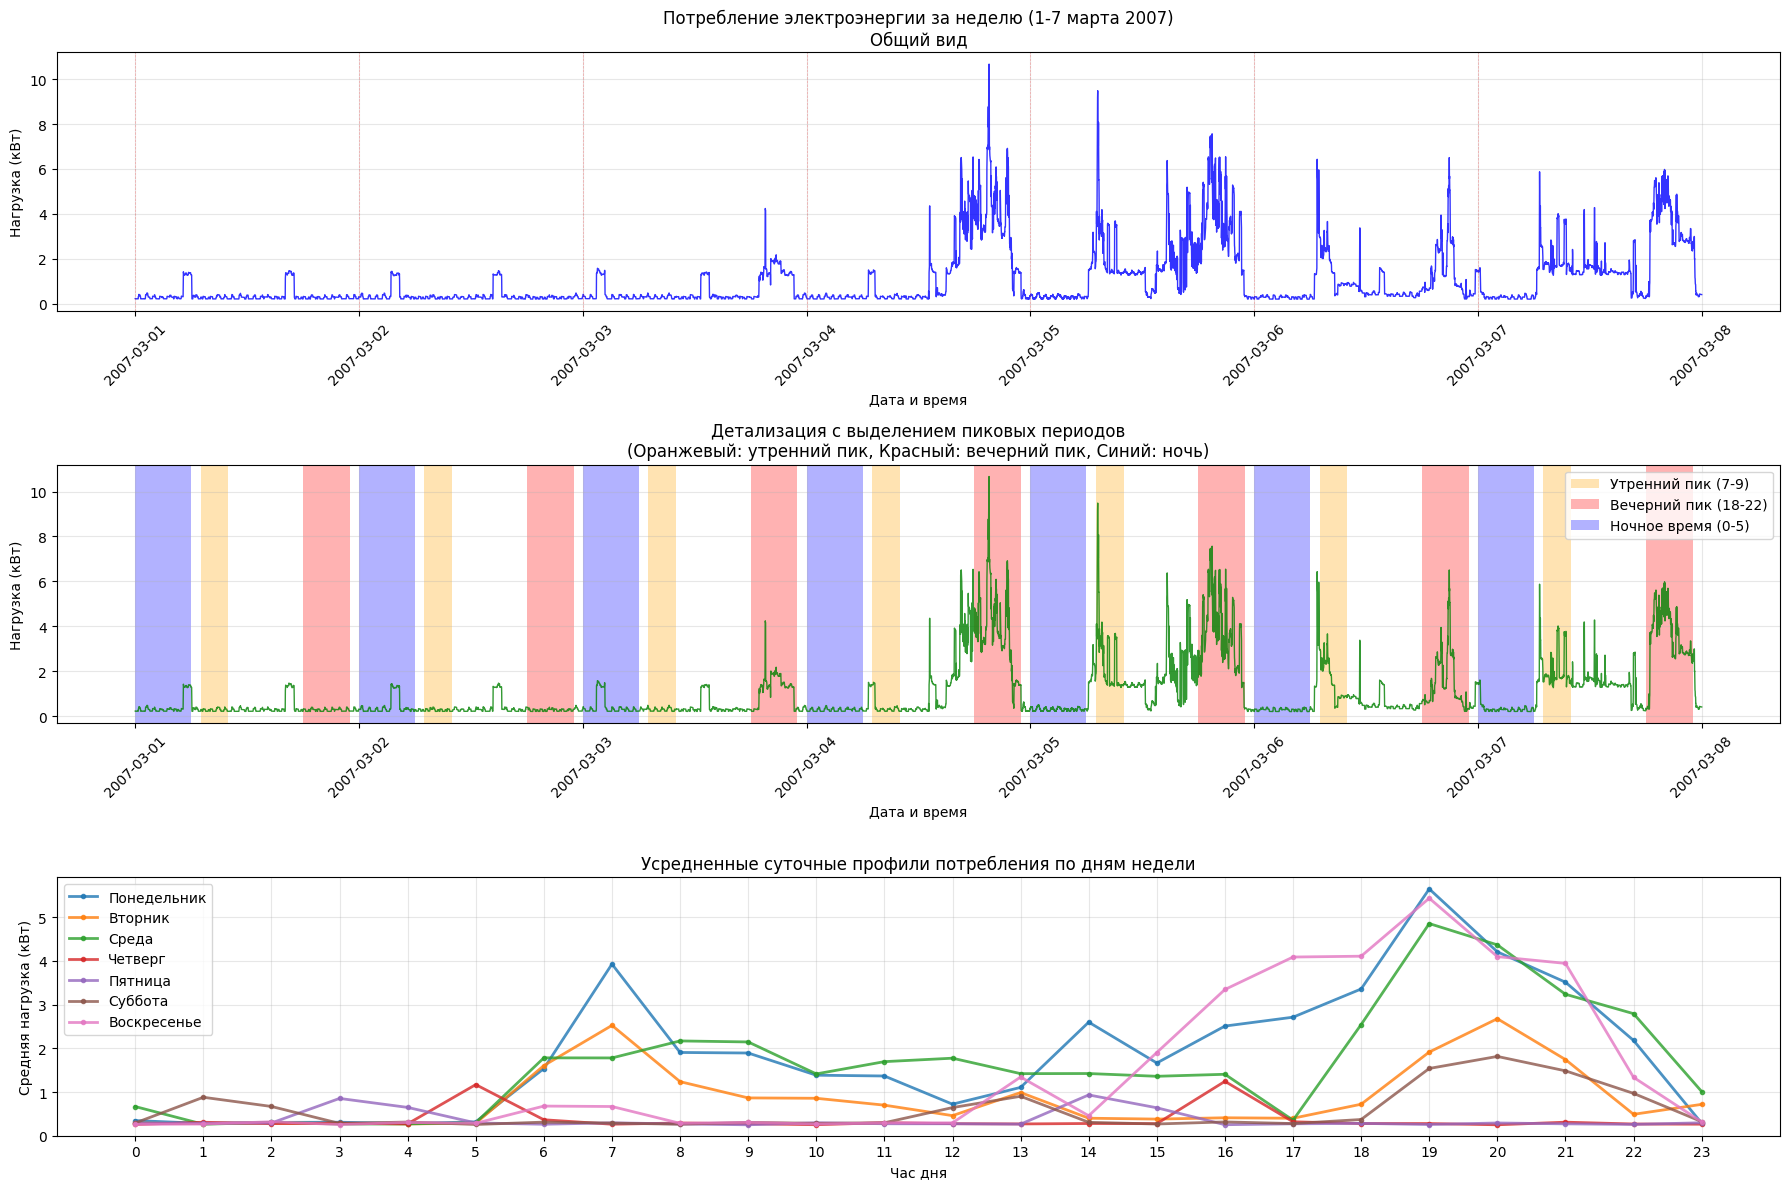


=== АНАЛИЗ ПАТТЕРНОВ ПОТРЕБЛЕНИЯ ===
Самые высокие пики потребления за неделю:
  2007-03-04 19:34:00: 10.67 кВт
  2007-03-04 19:33:00: 10.65 кВт
  2007-03-04 19:32:00: 10.15 кВт
  2007-03-04 19:35:00: 9.92 кВт
  2007-03-05 07:13:00: 9.49 кВт

Периоды высокого потребления (> 3.0 кВт):
  Количество записей: 882
  Общая продолжительность: 882 минут
  Максимальная продолжительность непрерывного высокого потребления: ...

Периоды низкого потребления (< 0.3 кВт):
  Количество записей: 3397
  Общая продолжительность: 3397 минут

=== АНАЛИЗ ПЕРЕХОДНЫХ ПРОЦЕССОВ ===
Резкие увеличения потребления (> +1.0 кВт/мин): 115
Резкие уменьшения потребления (< -1.0 кВт/мин): 106
Самое резкое увеличение: 2.71 кВт/мин
Самое резкое уменьшение: -3.08 кВт/мин


In [306]:
# ДЕТАЛЬНЫЙ АНАЛИЗ ВРЕМЕННОГО РЯДА
print("="*60)
print("ДЕТАЛЬНЫЙ АНАЛИЗ ВРЕМЕННОГО РЯДА")
print("="*60)

# Выбираем неделю для демонстрации (1-7 марта 2007)
sample_week = df['2007-03-01':'2007-03-07']

print("Анализ выбранной недели (1-7 марта 2007):")
print(f"Период: {sample_week.index.min()} - {sample_week.index.max()}")
print(f"Количество записей: {len(sample_week):,}")
print(f"Среднее потребление за неделю: {sample_week['Global_active_power'].mean():.3f} кВт")
print(f"Максимальное потребление: {sample_week['Global_active_power'].max():.3f} кВт")
print(f"Минимальное потребление: {sample_week['Global_active_power'].min():.3f} кВт")

# Анализ по дням недели в выбранной неделе
print(f"\n=== ПОТРЕБЛЕНИЕ ПО ДНЯМ ВЫБРАННОЙ НЕДЕЛИ ===")
daily_stats_week = sample_week.groupby('day_of_week')['Global_active_power'].agg(['mean', 'max', 'min'])
for day in sorted(daily_stats_week.index):
    day_name = days_map[day]
    stats = daily_stats_week.loc[day]
    print(f"{day_name}: {stats['mean']:.3f} кВт (макс: {stats['max']:.2f} кВт, мин: {stats['min']:.2f} кВт)")

# Анализ пиковых периодов в выбранной неделе
print(f"\n=== ПИКОВЫЕ ПЕРИОДЫ В ВЫБРАННОЙ НЕДЕЛЕ ===")
morning_peak_week = sample_week[sample_week['is_morning_peak'] == 1]['Global_active_power'].mean()
evening_peak_week = sample_week[sample_week['is_evening_peak'] == 1]['Global_active_power'].mean()
night_week = sample_week[sample_week['is_night'] == 1]['Global_active_power'].mean()

print(f"🌅 Утренний пик (7-9): {morning_peak_week:.3f} кВт")
print(f"🌇 Вечерний пик (18-22): {evening_peak_week:.3f} кВт")
print(f"🌙 Ночное время (0-5): {night_week:.3f} кВт")

# Визуализация
plt.figure(figsize=(18, 12))

# График 1: Общий вид недели
plt.subplot(3, 1, 1)
plt.plot(sample_week.index, sample_week['Global_active_power'], linewidth=1, color='blue', alpha=0.8)
plt.title('Потребление электроэнергии за неделю (1-7 марта 2007)\nОбщий вид')
plt.xlabel('Дата и время')
plt.ylabel('Нагрузка (кВт)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Добавляем вертикальные линии для разделения дней
unique_days = sample_week.index.normalize().unique()
for day in unique_days:
    plt.axvline(x=day, color='red', linestyle='--', alpha=0.3, linewidth=0.5)

# График 2: Детализация с выделением пиковых периодов
plt.subplot(3, 1, 2)
plt.plot(sample_week.index, sample_week['Global_active_power'], linewidth=1, color='green', alpha=0.8)

# Выделяем пиковые периоды цветом
for idx, row in sample_week.iterrows():
    if row['is_morning_peak'] == 1:
        plt.axvspan(idx, idx + pd.Timedelta(minutes=1), alpha=0.3, color='orange', linewidth=0)
    elif row['is_evening_peak'] == 1:
        plt.axvspan(idx, idx + pd.Timedelta(minutes=1), alpha=0.3, color='red', linewidth=0)
    elif row['is_night'] == 1:
        plt.axvspan(idx, idx + pd.Timedelta(minutes=1), alpha=0.3, color='blue', linewidth=0)

plt.title('Детализация с выделением пиковых периодов\n(Оранжевый: утренний пик, Красный: вечерний пик, Синий: ночь)')
plt.xlabel('Дата и время')
plt.ylabel('Нагрузка (кВт)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Добавляем легенду для цветовых зон
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='orange', alpha=0.3, label='Утренний пик (7-9)'),
    Patch(facecolor='red', alpha=0.3, label='Вечерний пик (18-22)'),
    Patch(facecolor='blue', alpha=0.3, label='Ночное время (0-5)')
]
plt.legend(handles=legend_elements, loc='upper right')

# График 3: Сравнение дней недели (усредненные суточные профили)
plt.subplot(3, 1, 3)

# Создаем усредненные профили для каждого дня недели
for day in sorted(sample_week['day_of_week'].unique()):
    day_data = sample_week[sample_week['day_of_week'] == day]
    hourly_profile = day_data.groupby('hour')['Global_active_power'].mean()
    
    plt.plot(hourly_profile.index, hourly_profile.values, 
             marker='o', markersize=3, linewidth=2, 
             label=days_map[day], alpha=0.8)

plt.title('Усредненные суточные профили потребления по дням недели')
plt.xlabel('Час дня')
plt.ylabel('Средняя нагрузка (кВт)')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24))
plt.legend()
plt.ylim(bottom=0)  # Начинаем с 0 для лучшей визуализации

plt.tight_layout()
plt.show()

# Дополнительный анализ паттернов
print(f"\n=== АНАЛИЗ ПАТТЕРНОВ ПОТРЕБЛЕНИЯ ===")

# Находим самые высокие пики за неделю
top_peaks = sample_week.nlargest(5, 'Global_active_power')[['Global_active_power']]
print("Самые высокие пики потребления за неделю:")
for timestamp, row in top_peaks.iterrows():
    print(f"  {timestamp}: {row['Global_active_power']:.2f} кВт")

# Анализ продолжительности высокого потребления
high_consumption_threshold = 3.0  # кВт
high_consumption_periods = sample_week[sample_week['Global_active_power'] > high_consumption_threshold]
print(f"\nПериоды высокого потребления (> {high_consumption_threshold} кВт):")
print(f"  Количество записей: {len(high_consumption_periods)}")
print(f"  Общая продолжительность: {len(high_consumption_periods)} минут")
print(f"  Максимальная продолжительность непрерывного высокого потребления: ...")

# Анализ низкого потребления
low_consumption_threshold = 0.3  # кВт
low_consumption_periods = sample_week[sample_week['Global_active_power'] < low_consumption_threshold]
print(f"\nПериоды низкого потребления (< {low_consumption_threshold} кВт):")
print(f"  Количество записей: {len(low_consumption_periods)}")
print(f"  Общая продолжительность: {len(low_consumption_periods)} минут")

# Анализ переходных процессов
print(f"\n=== АНАЛИЗ ПЕРЕХОДНЫХ ПРОЦЕССОВ ===")
# Вычисляем изменения потребления между соседними измерениями
sample_week['power_change'] = sample_week['Global_active_power'].diff()
large_increases = sample_week[sample_week['power_change'] > 1.0]  # Резкие увеличения > 1 кВт
large_decreases = sample_week[sample_week['power_change'] < -1.0]  # Резкие уменьшения > 1 кВт

print(f"Резкие увеличения потребления (> +1.0 кВт/мин): {len(large_increases)}")
print(f"Резкие уменьшения потребления (< -1.0 кВт/мин): {len(large_decreases)}")

if len(large_increases) > 0:
    print(f"Самое резкое увеличение: {large_increases['power_change'].max():.2f} кВт/мин")
if len(large_decreases) > 0:
    print(f"Самое резкое уменьшение: {large_decreases['power_change'].min():.2f} кВт/мин")

ДЕТАЛЬНЫЙ АНАЛИЗ АВТОКОРРЕЛЯЦИИ ВРЕМЕННОГО РЯДА
Анализ дневных данных:
Период: 2007-01-01 00:00:00 - 2007-06-30 00:00:00
Количество дней: 181
Среднее дневное потребление: 1.156 кВт
Стандартное отклонение: 0.537 кВт

=== ЧИСЛОВОЙ АНАЛИЗ АВТОКОРРЕЛЯЦИИ ===
Автокорреляционная функция (ACF):
Лаг  Корреляция  Интерпретация
 1   +0.4915    📊 Средняя
 7   +0.4008    📊 Средняя
14   +0.3065    📊 Средняя
21   +0.2607    📉 Низкая
30   +0.0613    📉 Низкая

Частичная автокорреляционная функция (PACF):
Лаг  Корреляция  Интерпретация
 1   +0.4942    📊 Средняя
 2   +0.0281    📉 Низкая
 3   +0.3606    📊 Средняя
 7   +0.1191    📉 Низкая
14   +0.0792    📉 Низкая

=== АНАЛИЗ СЕЗОННЫХ ПАТТЕРНОВ ===
📅 Выраженная недельная сезонность: ACF(7) = +0.4008

=== АНАЛИЗ ПАМЯТИ ПРОЦЕССА ===
📊 Процесс имеет память примерно 3 дней


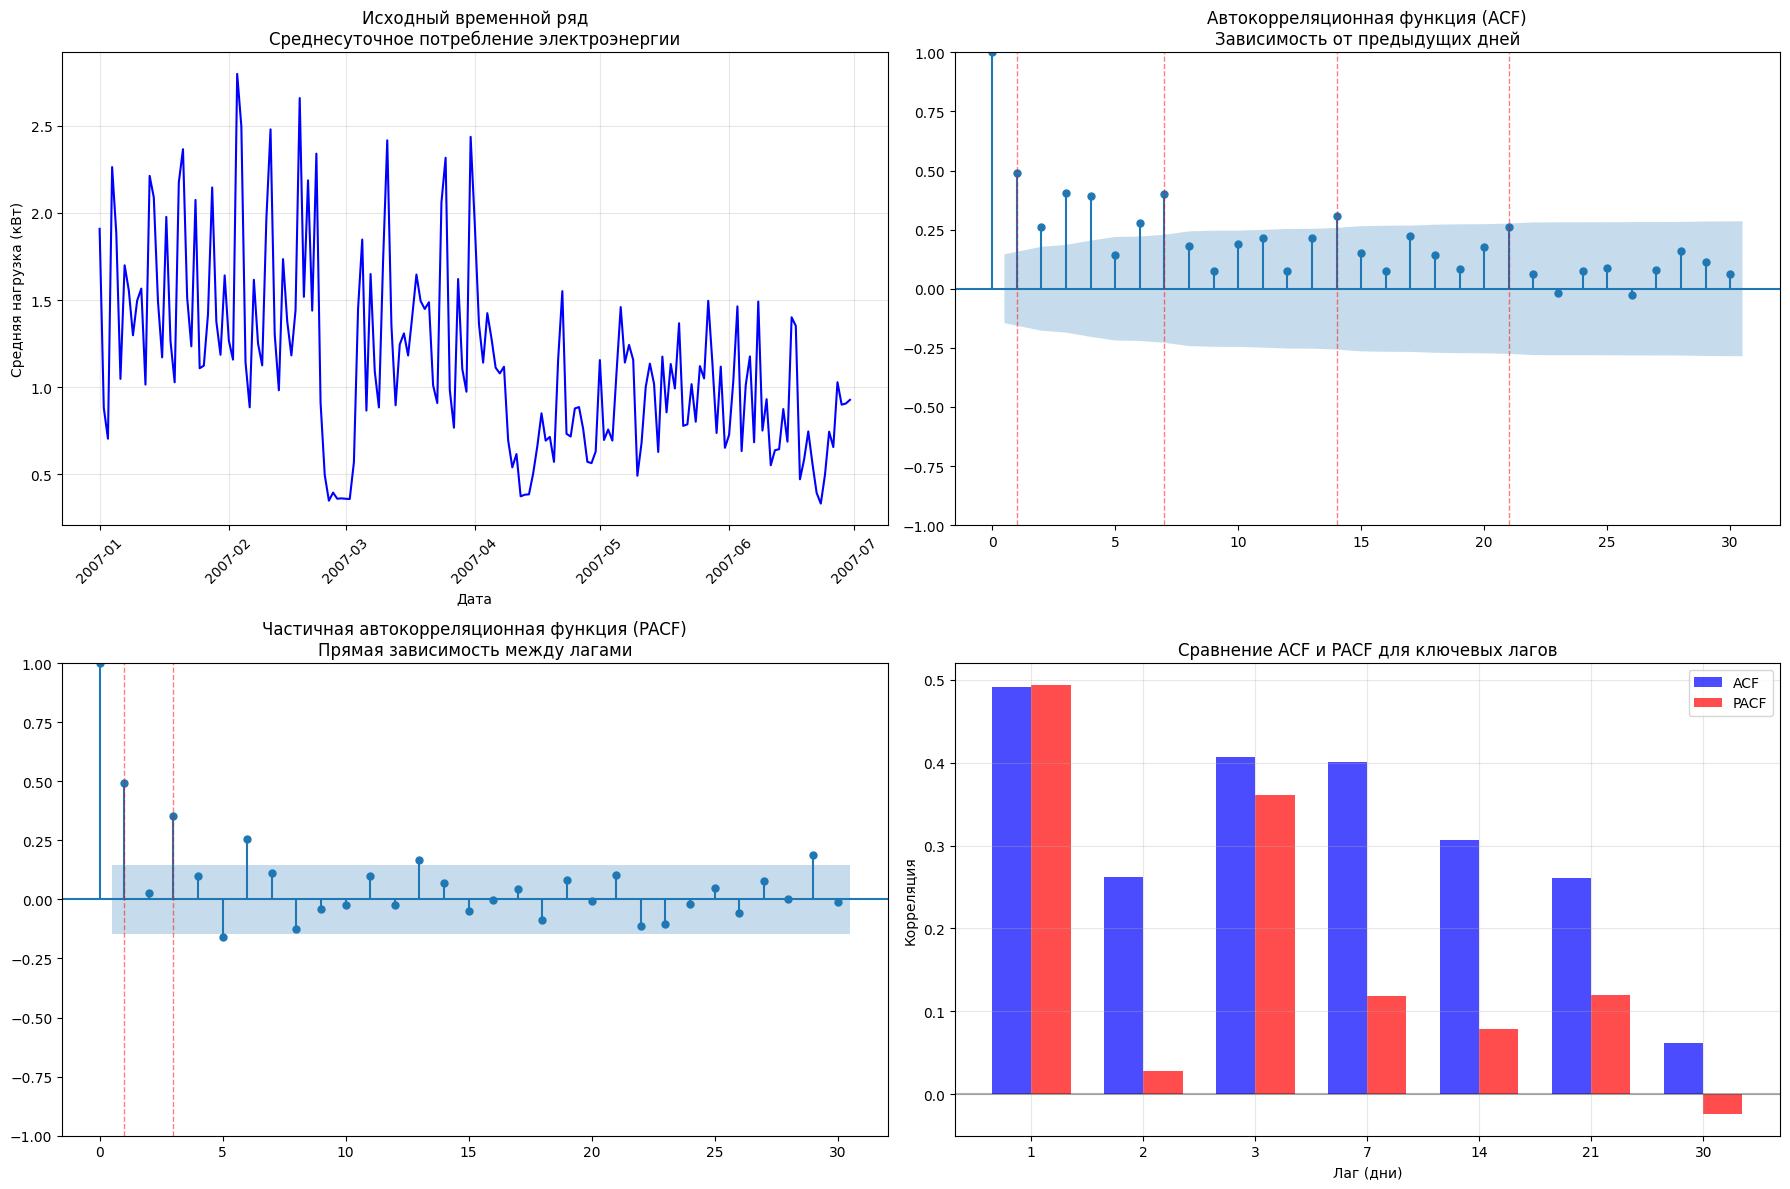

In [307]:
# ДЕТАЛЬНЫЙ АНАЛИЗ АВТОКОРРЕЛЯЦИИ
print("="*60)
print("ДЕТАЛЬНЫЙ АНАЛИЗ АВТОКОРРЕЛЯЦИИ ВРЕМЕННОГО РЯДА")
print("="*60)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import numpy as np

# Берем дневные средние для лучшей визуализации
daily_data = df['Global_active_power'].resample('D').mean()

print("Анализ дневных данных:")
print(f"Период: {daily_data.index.min()} - {daily_data.index.max()}")
print(f"Количество дней: {len(daily_data)}")
print(f"Среднее дневное потребление: {daily_data.mean():.3f} кВт")
print(f"Стандартное отклонение: {daily_data.std():.3f} кВт")

# Вычисляем числовые значения ACF и PACF
lags = 30
acf_values = acf(daily_data, nlags=lags)
pacf_values = pacf(daily_data, nlags=lags)

print(f"\n=== ЧИСЛОВОЙ АНАЛИЗ АВТОКОРРЕЛЯЦИИ ===")
print("Автокорреляционная функция (ACF):")
print("Лаг  Корреляция  Интерпретация")
significant_lags_acf = []
for lag in [1, 7, 14, 21, 30]:
    if lag <= lags:
        correlation = acf_values[lag]
        interpretation = "✅ Высокая" if abs(correlation) > 0.5 else "📊 Средняя" if abs(correlation) > 0.3 else "📉 Низкая"
        if abs(correlation) > 0.2:  # Статистически значимая
            significant_lags_acf.append(lag)
        print(f"{lag:2d}   {correlation:+.4f}    {interpretation}")

print(f"\nЧастичная автокорреляционная функция (PACF):")
print("Лаг  Корреляция  Интерпретация")
significant_lags_pacf = []
for lag in [1, 2, 3, 7, 14]:
    if lag <= lags:
        correlation = pacf_values[lag]
        interpretation = "✅ Высокая" if abs(correlation) > 0.5 else "📊 Средняя" if abs(correlation) > 0.3 else "📉 Низкая"
        if abs(correlation) > 0.2:  # Статистически значимая
            significant_lags_pacf.append(lag)
        print(f"{lag:2d}   {correlation:+.4f}    {interpretation}")

# Анализ сезонности
print(f"\n=== АНАЛИЗ СЕЗОННЫХ ПАТТЕРНОВ ===")
weekly_seasonality = acf_values[7] if 7 <= lags else 0
if abs(weekly_seasonality) > 0.3:
    print(f"📅 Выраженная недельная сезонность: ACF(7) = {weekly_seasonality:+.4f}")
else:
    print(f"📅 Слабая недельная сезонность: ACF(7) = {weekly_seasonality:+.4f}")

# Анализ памяти процесса
print(f"\n=== АНАЛИЗ ПАМЯТИ ПРОЦЕССА ===")
if len(significant_lags_pacf) > 0:
    memory_length = max(significant_lags_pacf)
    print(f"📊 Процесс имеет память примерно {memory_length} дней")
else:
    print(f"📊 Процесс имеет короткую память (1-2 дня)")

# Визуализация
plt.figure(figsize=(18, 12))

# График 1: Исходный временной ряд (дневные данные)
plt.subplot(2, 2, 1)
plt.plot(daily_data.index, daily_data.values, linewidth=1.5, color='blue')
plt.title('Исходный временной ряд\nСреднесуточное потребление электроэнергии')
plt.xlabel('Дата')
plt.ylabel('Средняя нагрузка (кВт)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# График 2: Автокорреляционная функция (ACF)
plt.subplot(2, 2, 2)
plot_acf(daily_data, lags=30, ax=plt.gca(), alpha=0.05, 
         title='Автокорреляционная функция (ACF)\nЗависимость от предыдущих дней')

# Выделяем значимые лаги
for lag in significant_lags_acf:
    if lag > 0:  # Пропускаем lag 0
        plt.axvline(x=lag, color='red', linestyle='--', alpha=0.5, linewidth=1)

# График 3: Частичная автокорреляционная функция (PACF)
plt.subplot(2, 2, 3)
plot_pacf(daily_data, lags=30, ax=plt.gca(), alpha=0.05,
          title='Частичная автокорреляционная функция (PACF)\nПрямая зависимость между лагами')

# Выделяем значимые лаги
for lag in significant_lags_pacf:
    if lag > 0:  # Пропускаем lag 0
        plt.axvline(x=lag, color='red', linestyle='--', alpha=0.5, linewidth=1)

# График 4: Сравнение ACF и PACF для ключевых лагов
plt.subplot(2, 2, 4)
key_lags = [1, 2, 3, 7, 14, 21, 30]
acf_key = [acf_values[lag] for lag in key_lags if lag <= lags]
pacf_key = [pacf_values[lag] for lag in key_lags if lag <= lags]

x_pos = np.arange(len(key_lags[:len(acf_key)]))
width = 0.35

plt.bar(x_pos - width/2, acf_key, width, label='ACF', alpha=0.7, color='blue')
plt.bar(x_pos + width/2, pacf_key, width, label='PACF', alpha=0.7, color='red')

plt.title('Сравнение ACF и PACF для ключевых лагов')
plt.xlabel('Лаг (дни)')
plt.ylabel('Корреляция')
plt.xticks(x_pos, key_lags[:len(acf_key)])
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

Тепловая карта сезонности:


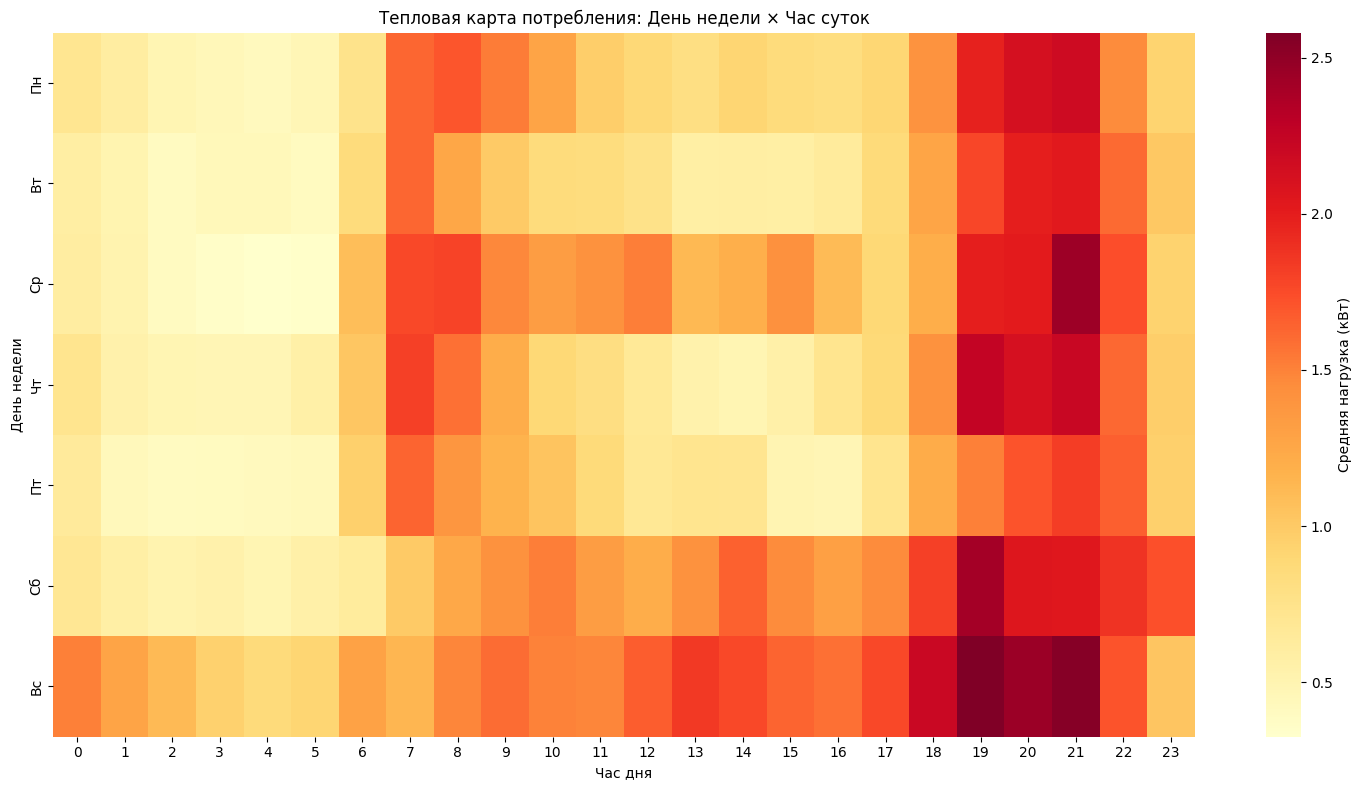

In [310]:
# Создаем тепловую карту "час дня × день недели"
print("Тепловая карта сезонности:")

# Группируем по часу и дню недели
heatmap_data = df.groupby(['day_of_week', 'hour'])['Global_active_power'].mean().unstack()

plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_data, 
            cmap='YlOrRd', 
            annot=False,  # Можно поставить True если хотите числа
            cbar_kws={'label': 'Средняя нагрузка (кВт)'})
plt.title('Тепловая карта потребления: День недели × Час суток')
plt.xlabel('Час дня')
plt.ylabel('День недели')
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], 
           labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.tight_layout()
plt.show()